### Team 39 Contributors:
* 20241457 Onni Mansikkamäki
* 20240506 Jan-Louis Schneider
* 20240945 Emir Kamiloglu
* 20240941 Tomás Figueiredo
* 20240661 Rita Santos

## Important: <br> The train_data.csv and test_data.csv should be in the same folder as this notebook in order to run the code without changes

# Import the needed libraries

In [11]:
%pip install summarytools
%pip install ipywidgets
## %pip install annoy (Doesn't work on Emir's)
%pip install tensorflow
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
## from annoy import AnnoyIndex
import phik
import warnings
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns
from summarytools import dfSummary
from math import ceil
from sklearn.model_selection import train_test_split
import scipy.stats as stats 

import joblib

## Import the Data

In [13]:
# Data imports
train_data_nosplit = pd.read_csv(r'train_data.csv')
test_data = pd.read_csv(r'test_data.csv')

/var/folders/hr/bvcr3w9n2gxgqdhjgthjjnv80000gn/T/ipykernel_1777/3099592670.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data_nosplit = pd.read_csv(r'train_data.csv')


### Create validation data from train_data (%80-%20 split rate)

In [14]:
# Split train_data into new training set and validation set

# First delete rows without Claim Injury Type
print(len(train_data_nosplit))
train_data_nosplit = train_data_nosplit.dropna(subset=["Claim Injury Type"])
print(len(train_data_nosplit))

y = train_data_nosplit["Claim Injury Type"]
train_data, validation_data = train_test_split(train_data_nosplit, test_size=0.2, random_state=39, stratify=y)

593471
574026


### 1.1 Check data contents, provide descriptive statistics and check for incoherencies in the data.

In [15]:
# Check for column names in training data
print(train_data.columns)

# First 5 rows of the training data
train_data.head()

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
512176,2022-08-08,58.0,N,2022-08-10,N,0.00,1964.0,2022-08-10,NaN,COUNTY OF ULSTER,...,99.0,"OTHER - MISCELLANEOUS, NOC",59.0,"ALL OTHER SPECIFIC INJURIES, NOC",53.0,KNEE,12548,0.0,Not Work Related,2.0
93556,NaN,0.0,N,2020-07-13,Y,0.00,NaN,2020-07-16,2020-07-03,NYC TRANSIT AUTHORITY,...,99.0,"OTHER - MISCELLANEOUS, NOC",78.0,CARPAL TUNNEL SYNDROME,90.0,MULTIPLE BODY PARTS (INCLUDING BODY,11412,0.0,Not Work Related,1.0
404619,2022-01-14,50.0,N,2022-02-09,N,0.00,1971.0,2022-02-09,NaN,STARR INDEMNITY & LIABILITY CO,...,80.0,OBJECT HANDLED BY OTHERS,40.0,LACERATION,14.0,EYE(S),18301,0.0,Not Work Related,2.0
508275,2022-07-28,49.0,N,2022-08-04,N,405.00,1973.0,2022-08-04,NaN,HARTFORD ACCIDENT & INDEMNITY,...,27.0,FROM LIQUID OR GREASE SPILLS,52.0,STRAIN OR TEAR,33.0,LOWER ARM,12590,0.0,Not Work Related,5.0
474207,2022-05-25,49.0,N,2022-06-08,Y,1784.02,1972.0,2022-06-08,2022-12-29,NASSAU HEALTH CARE CORP.,...,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,-9.0,MULTIPLE,11550,0.0,Not Work Related,1.0


In [16]:
# Check for column names in test data
train_data.columns

# Find column names that don't exist in the test data but exist in the training data
missing_cols = [col for col in train_data.columns if col not in test_data.columns]

print("These will be the columns and the types of the columns that are not in testing data.\n"
    "We will try to predict these columns: \n" + str(missing_cols))

These will be the columns and the types of the columns that are not in testing data.
We will try to predict these columns: 
['Claim Injury Type', 'Agreement Reached', 'WCB Decision']


#### These will be the columns and description of the column from metadata that are not in testing data. These are the columns we are trying to predict: 
 
| Claim Injury Type | Agreement Reached | WCB Decision |
|------------------|-----------------------------------------------------------------|--------------|
|     **Main target variable**: Deliberation of the WCB relative to benefits awarded to the claim. **Numbering indicates severity**.       |     **Binary variable**: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim    |   **Multiclass variable**: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim.    |

## Let's take more comprehensive look into data contents and let's make observations

In [17]:
# Check characteristics of the dataframe (null-values, data types, shape, etc.)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 459220 entries, 512176 to 310965
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       456267 non-null  object 
 1   Age at Injury                       459220 non-null  float64
 2   Alternative Dispute Resolution      459220 non-null  object 
 3   Assembly Date                       459220 non-null  object 
 4   Attorney/Representative             459220 non-null  object 
 5   Average Weekly Wage                 436273 non-null  float64
 6   Birth Year                          435932 non-null  float64
 7   C-2 Date                            447690 non-null  object 
 8   C-3 Date                            149721 non-null  object 
 9   Carrier Name                        459220 non-null  object 
 10  Carrier Type                        459220 non-null  object 
 11  Claim Identifier          

### Descriptive statistics

In [18]:
# Check summary of the data
dfSummary(train_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Accident Date[object],1. nan2. 2020-03-013. 2020-12-184. 2022-02-075. 2020-02-066. 2022-01-057. 2021-02-088. 2021-02-189. 2022-01-3110. 2020-01-0611. other,"2,953 (0.6%)1,005 (0.2%)808 (0.2%)769 (0.2%)698 (0.2%)695 (0.2%)690 (0.2%)677 (0.1%)673 (0.1%)670 (0.1%)449,582 (97.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADlklEQVR4nO3cQWojZxRG0VdGOO1JCSHwEpI9eBG92F6EFpE9GOMaxJ2eVAadhJBx+hYo54w0/AcXngz6vOz7PlB4OPoB/H+IjYzYyIiNjNjIiI2M2MiIjYzYyCwz8zQzs+/7x8Fv4c6drtfr55mZZVm+CI4f6WFd18u6rpeZeTz6Mdw339nIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcxp27a3Pz9/O/Ql3D0bBDKLf5lFxXc2Mg/LsvyyLMunox/C/XuYmZ9n5qejH8L9c0bJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mg8zMyvM/P70Q/h/tkgkHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlMwyM08z83j0Q7hb3/Z9/5iZOV2v18/rul6OfhH3adu2t2VZvuz7/nFa1/Xy8vLycT6fvx79MO7L+/v7p9vtdnl9fX2cmY/TzMz5fP76/Pz828Fv4z49/fXBHwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkTjPffwpy9EO4P//u6rRt29vtdrvMP34KAv+VbdveZubbjJ+F8+P9/bNw6yoy/kAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzBzYDflba1o3nAAAAAElFTkSuQmCC"">","2,953(0.6%)"
2,Age at Injury[float64],Mean (sd) : 42.1 (14.3)min < med < max:0.0 < 42.0 < 117.0IQR (CV) : 23.0 (3.0),105 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACiElEQVR4nO3dvW7aUBiH8feUD9kgGaFIsHEDlRgYuYhebC+hA1fAysSGQAgEjYMx7pQqVUlS++Daf+v57Sec4TGJP/LaZVlmQN19qXoDwL9oV72BjzjnQjPrFlx+ybLs+ZH7QXVqG6pzLnx6evoWRdGwyPrj8bh3zn0vGisHSb3UNlQz60ZRNJzP58+DwSDOs/BwOASLxWK42+26ZpY7mKoPEvytzqGamdlgMIhHo9HPAktDj4+t7CDBfbUPtUoVHSS4g7N+SCBUSCBUSCBUSCBUSCBUSGjs5ak0TTtmFjnniiyPbrdb58FbgodGhno+nztJkkwnk0mr1WrlumBvZpYkSZCm6dc4jn+YWZHrqHiwRoZ6uVzaQRD0ZrNZPB6P93nXr9fr4XK57F2v11YZ+0N+jQz1Vb/fL3Rnab/fc2epZjiZggRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChYRG/3NfVTxnCjCt+g5CfTDfmQJMq76PUB/MZ6YA06rfR6glKTpTwJhWfRcnU5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBQ6gV/zzc0M0cfv5UWqu8bmpmjj7fK/EYt/IZmM+bo40+l3+sv+oZm5ujjLU6mIIFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFJKTXjOWDNrKFD1j4N1eMpfZ7Qz8l3wJpZc4esfRiqz1P6PKGfn8+ANbNmD1n77Bu1G0XRcDqdWhiGL3l+8Ha7DVarVe9wOPQ3m80l78ZOp1NgZnY+n4PNZtP7X2ur/OzXtT7SNG2b358OVXnJsuzd3yK/AFkxIPmhibpmAAAAAElFTkSuQmCC"">",0(0.0%)
3,Alternative Dispute Resolution[object],1. N2. Y3. U,"457,169 (99.6%)2,050 (0.4%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABeklEQVR4nO3csW3bUBiF0f8RRBw3JAQCGsHZQUO49Z4ZQkNkCUEsYlsNXdgeQfcB9DmVylt8EEmBT23btoKEofcAfo5WVY9V9av3EHbvNi7L8jxN06H3EvZtXdfLOE3T4XQ6vc7z/NZ7EPt0vV5/n8/nw1hVNc/z2/F4/N97FLv26AGBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFj1ef7Rr2HsF/ffbVlWV68qcu9ret6cQaBlFtzlI+U72+22rbttfMWdm5cluW5qqq19ldw3NMwTdPh6wHBfRt35Xc2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixETOu63r5+nzruoTdcwaBGKeriHHPRozYiBlaa39aa/7rg7sbquqpqh56D2H/XEaJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGzFBV/6rqvfcQ9s/pKmJcRon5ACasPKRhHTSDAAAAAElFTkSuQmCC"">",0(0.0%)
4,Assembly Date[object],1. 2020-03-062. 2021-05-113. 2022-04-014. 2022-02-045. 2022-08-156. 2021-08-037. 2

In [19]:
# Check the descriptive statistics for non-object values
train_data.describe(exclude='object').round(2)

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,459220.00,436273.00,435932.00,459220.00,106416.00,451340.00,0.0,446840.00,446822.00,445682.00,459220.00,459220.00
mean,42.12,494.32,1887.10,5778711.06,3.21,58.66,NaN,54.37,41.02,39.74,0.05,3.01
std,14.26,6763.18,413.91,222308.56,2.83,19.65,NaN,25.88,22.20,22.35,0.21,2.00
min,0.00,0.00,0.00,5393066.00,1.00,11.00,NaN,1.00,1.00,-9.00,0.00,0.00
25%,31.00,0.00,1965.00,5586467.75,1.00,45.00,NaN,31.00,16.00,33.00,0.00,1.00
50%,42.00,0.00,1977.00,5777839.50,2.00,61.00,NaN,56.00,49.00,38.00,0.00,3.00
75%,54.00,840.50,1989.00,5970992.50,4.00,71.00,NaN,75.00,52.00,53.00,0.00,5.00
max,117.00,2828079.00,2014.00,6165685.00,73.00,92.00,NaN,99.00,91.00,99.00,1.00,6.00


In [20]:
# Check the descriptive statistics for object values
train_data.describe(include='object')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,...,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,456267,459220,459220,459220,447690,149721,459220,459220,459220,459220,...,459220,120525,459220,451340,459220,446840,446822,445682,436330,459220
unique,4930,3,891,2,2256,1618,2011,8,8,63,...,8,1094,4,20,5,74,55,54,9127,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2020-10-26,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,...,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1005,457169,1135,313884,1496,292,88979,228074,232862,48445,...,216666,353,268104,91477,212953,37220,122536,41444,2660,459220


In [21]:
# Check for duplicates
train_data.duplicated().sum()

0

In [22]:
# Check data for missing values
train_data.isna().sum()

# We can already replace empty strings "" by nans
train_data.replace("", np.nan, inplace=True)

# Check data for missing values again
train_data.isna().sum()

Accident Date                           2953
Age at Injury                              0
Alternative Dispute Resolution             0
Assembly Date                              0
Attorney/Representative                    0
Average Weekly Wage                    22947
Birth Year                             23288
C-2 Date                               11530
C-3 Date                              309499
Carrier Name                               0
Carrier Type                               0
Claim Identifier                           0
Claim Injury Type                          0
County of Injury                           0
COVID-19 Indicator                         0
District Name                              0
First Hearing Date                    338695
Gender                                     0
IME-4 Count                           352804
Industry Code                           7880
Industry Code Description               7880
Medical Fee Region                         0
OIICS Natu

### Find metric and non-metric columns from data. Store the column names to lists so that they can be easily accessed.

In [23]:
# Find all metric and non-metric columns
non_metric_cols = list(train_data.describe(include='object').columns)
metric_cols = list(train_data.describe(exclude='object').columns)

# At this point, while studying relationships of fetaure variables, we can exclude variables that we are trying to predict
non_metric_cols.remove('WCB Decision')
non_metric_cols.remove('Claim Injury Type')
metric_cols.remove('Agreement Reached')

# Check the columns
print("Non-metric columns: \n" + str(non_metric_cols))
print("Metric columns: \n" + str(metric_cols))

# Move some columns (identified as categorial/non-metric) to non-metric columns and remove from metric columns

# Claim identifier (just an identifier)
non_metric_cols.append('Claim Identifier')
metric_cols.remove('Claim Identifier')

# Industry code (categorical)
non_metric_cols.append('Industry Code')
metric_cols.remove('Industry Code')

# OIICS Nature of Injury Description (categorical)
non_metric_cols.append('OIICS Nature of Injury Description')
metric_cols.remove('OIICS Nature of Injury Description')

# WCIO Cause of Injury Code, WCIO Nature of Injury Code, WCIO Part Of Body Code (categorical)
non_metric_cols.append('WCIO Cause of Injury Code')
non_metric_cols.append('WCIO Nature of Injury Code')
non_metric_cols.append('WCIO Part Of Body Code')

metric_cols.remove('WCIO Cause of Injury Code')
metric_cols.remove('WCIO Nature of Injury Code')
metric_cols.remove('WCIO Part Of Body Code')


# Check the columns again
print("Non-metric columns: \n" + str(non_metric_cols))
print("Metric columns: \n" + str(metric_cols))

# Check that all columns (but three, the ones we are predicting) are accounted for
print(len(train_data.columns))
print(len(non_metric_cols) + len(metric_cols))

# Check that not any non-metric column is in the metric columns
for col in non_metric_cols:
    if col in metric_cols:
        print(col)

Non-metric columns: 
['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code']
Metric columns: 
['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents']
Non-metric columns: 
['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Me

In [24]:
#NOTE: Commented out to not crash the jupyter notebook with the large number of plots and long html output

#NOTE: IF you want to run the y-profiling and see the Profile Report, uncomment the code below


# %pip install ydata-profiling
# from ydata_profiling import ProfileReport

# # To get initial but comprehensive report on the data (missing values, types of data etc)
# profile = ProfileReport(
#     train_data,
#     title='New York Workers’ Compensation Board Data',
#     correlations={
#         "pearson": {"calculate": True},   # Linear correlation
#         "spearman": {"calculate": True},  # Non-linear/ordinal correlation
#         "kendall": {"calculate": False},   
#         "phi_k": {"calculate": True},     # Categorical correlation
#         "cramers": {"calculate": True},   # Association between categorical variables
#     },
#     missing_diagrams={
#         "bar": True,          # Bar chart for missing data
#         "matrix": True,       # Heatmap-like missing data matrix
#         "dendrogram": True,   # Hierarchical clustering of missing values
#     }
# )

# profile.to_notebook_iframe()

## Visual data explorations

First we plot Histograms of all Numeric Variables in order to get a better overview over the Variables and its Distributions

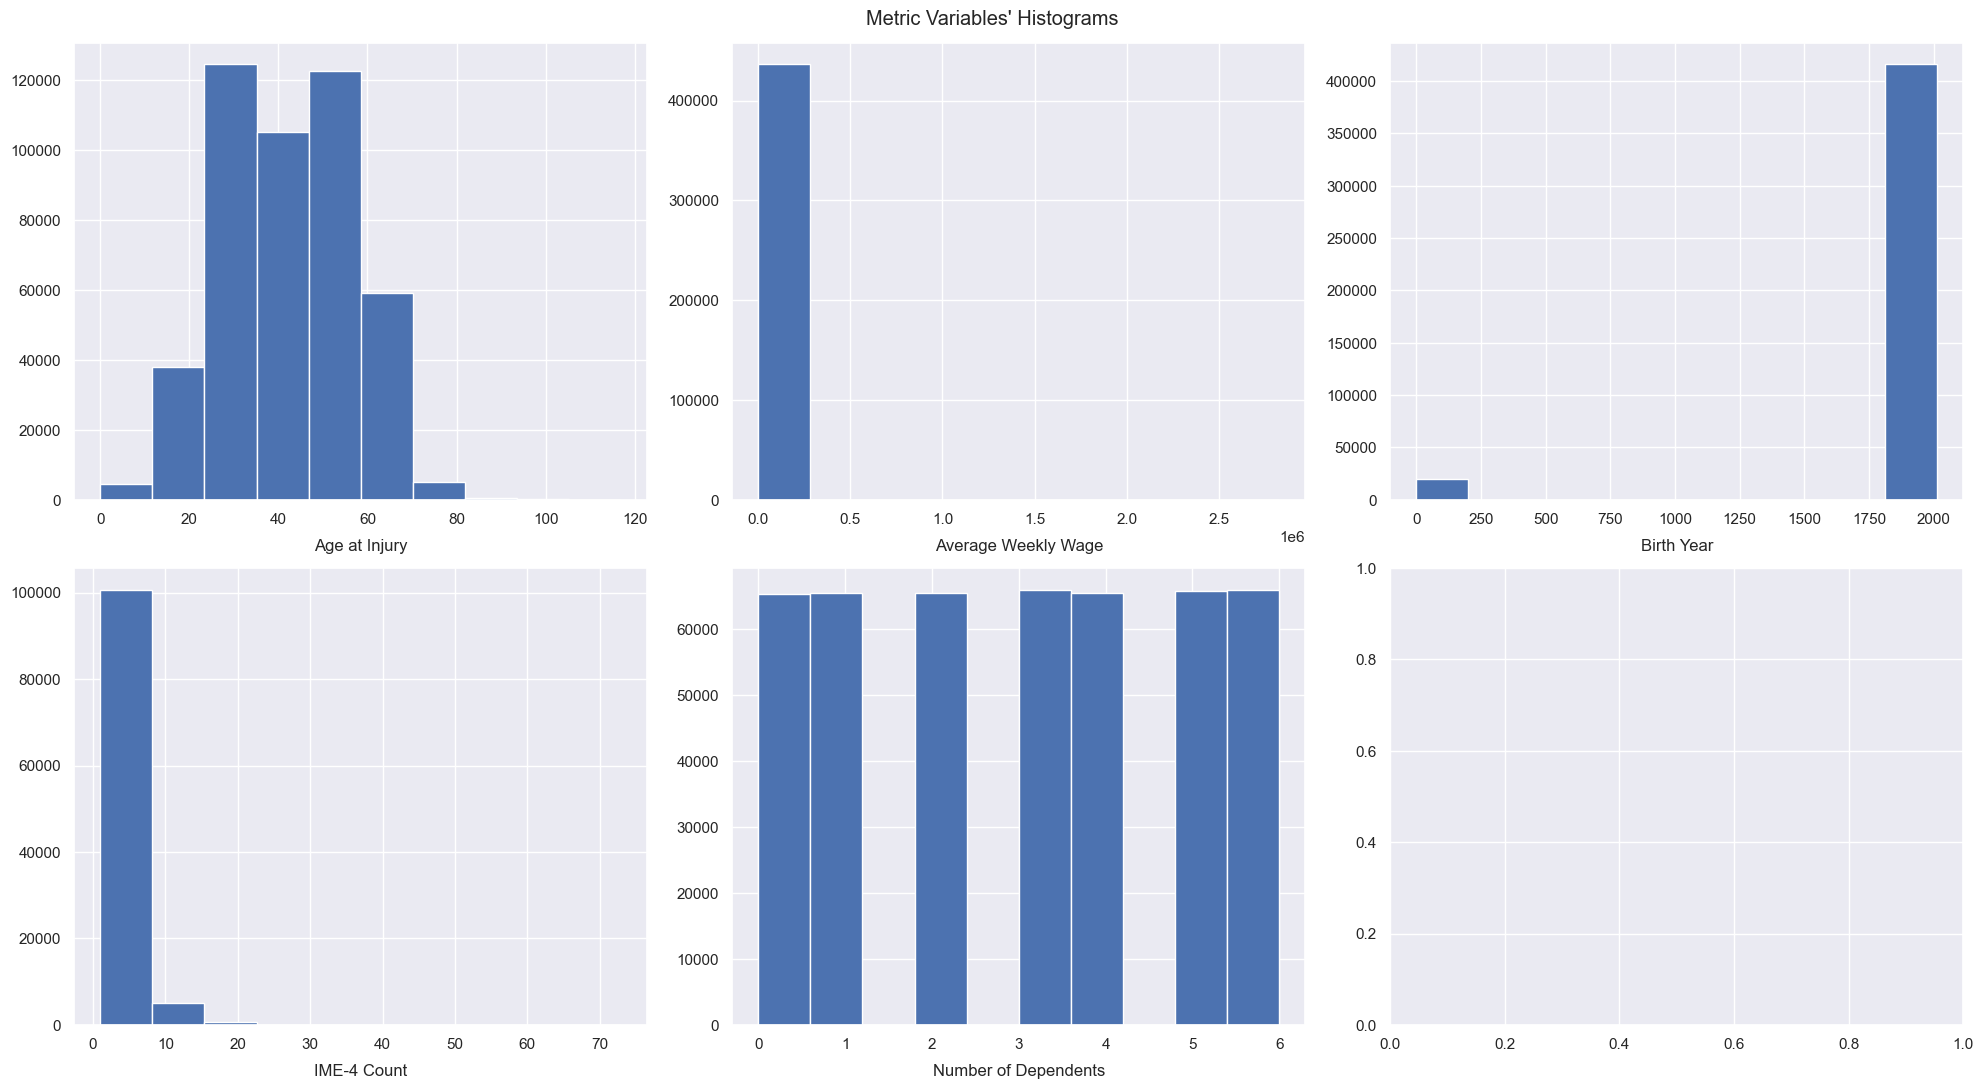

In [25]:
# Plot all Numeric Variables' Histograms in one figure

sns.set() ## Reset to darkgrid

# Prepare figure. Create individual axes where each histogram will be placed
sp_rows = 2
sp_cols = ceil(len(metric_cols) / sp_rows) 


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                        tight_layout=True)

# Plot data
# Iterate across axes objects and associate each histogram
for ax, feat in zip(axes.flatten(), metric_cols): 
    ax.hist(train_data[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Histograms"

plt.suptitle(title)

plt.show()

With Boxplots for all Numeric Variables we get further visual insights in our data, especially concerning possible outliers

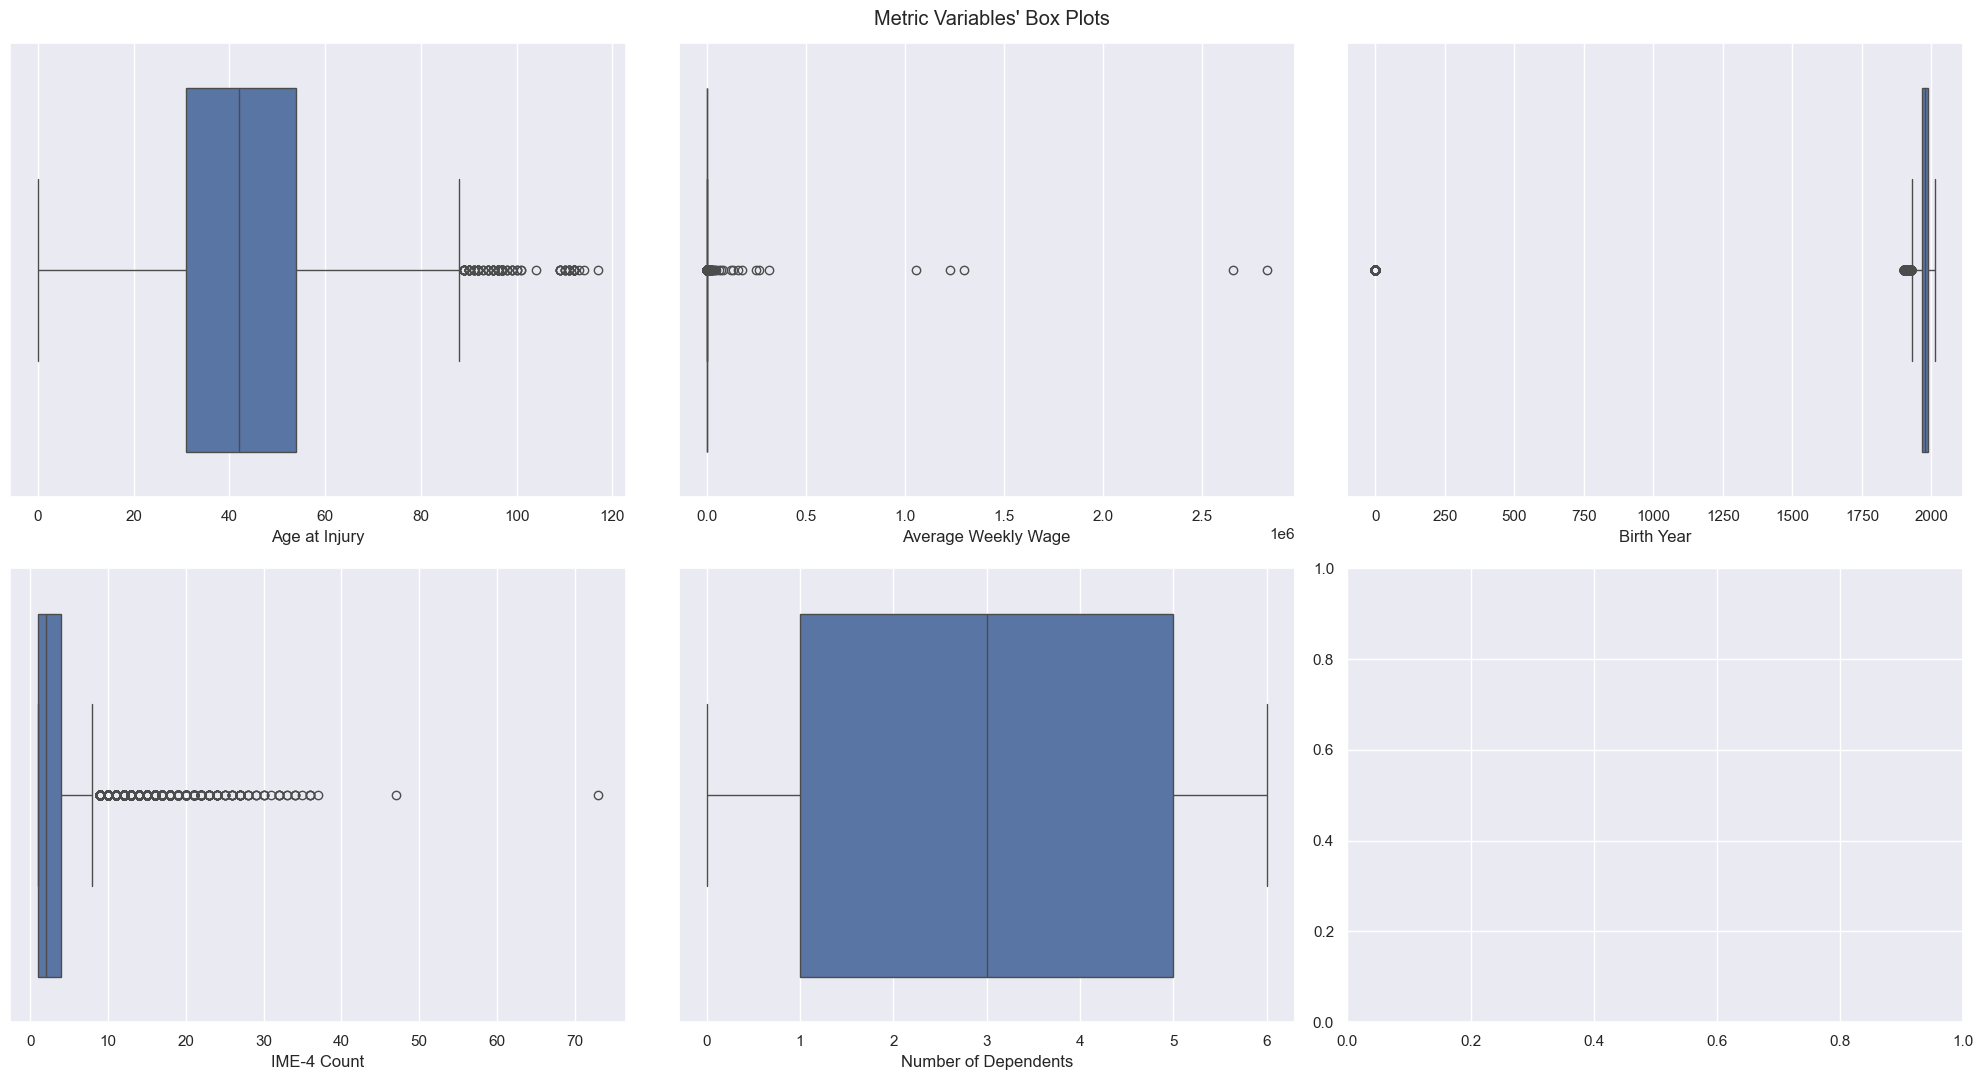

In [26]:
# Plot ALL Numeric Variables' Boxplots in one figure

sns.set() ## Reset to darkgrid

sp_rows = 2
sp_cols = ceil(len(metric_cols) / sp_rows)


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                         tight_layout=True
                        )

# Plot data
# Iterate across axes objects and associate each histogram 
for ax, feat in zip(axes.flatten(), metric_cols): 
    sns.boxplot(x=train_data[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Box Plots"

plt.suptitle(title)

plt.show()

# Notes, incoherensies and Conclusions on Data Exploration (!!! THIS PART WILL BE UPDATED)


* General:
    * Number of dependents -column is not in metadata. It maybe refers to to the number of people who are financially dependent on the injured worker.
    * OIICS Nature of Injury is full of missing values
    * Few of the columns had class imbalances (mentioned below)
    * **Target variable: WCB Decision** is either missing(3.3% of cases) or **always** just Non work related

* Null-values and missing values:
    ![image.png](attachment:image.png)



* Incoherensies
    * **19445 seems to be usual number for missing values!! --> Probably 19445 rows with null-values in almost every field. Those probably can be deleted**
    * **OIICS Nature of Injury is that full of missing values!!**
    * Accident date: 23134 missing values (3.9% of data)
    * Age at injury: 19445 missing values (3.3% of data)
    * Alternative Dispute Resolution: 19445 missing values (3.3% of data)
    * Attorney/Rep... : 19445 missing values (3.3% of data)
    * Averegae weekly wage:
        * Missing: (8.1%)
        * **Zeros: 335450 so over 56% of data is zeros**
    * Birth year:
        * Missing values (8.1%)
        * Zeros (4.2%)
    * C-2 date: 5.7% missing
    * C-3 date: **68.4% missing**
    * Carrier name: 19445 missing values (3.3% of data)
    * Carrier type: 19445 missing values (3.3% of data)
    * County of injury: 19445 missing values (3.3% of data)
    * COVID 19 Indicator: 19445 missing values (3.3% of data)
    * Gender, District Name, First hearing date: 19445 missing values (3.3% of data)
    * IM-4 Count: **77.6% Missing**
    * Industry code: 5% Missing
    * Industry code Desc.: Same as above
    * Medical Fee Region: 19445 missing values (3.3% of data)
    * ALL WCIO.. columns: 5.9-6.2 % Missing
    * Zip Code: 8% missing
    * **TARGET VARIABLE Agreement Reached: 19445 missing values (3.3% of data)**
    * **TARGET VARIABLE: Claim injury type: 19445 missing values (3.3% of data)**
    * **TARGET VARIABLE: WCB Decision: 19445 missing values (3.3% of data)**
    
    

* Types:
    * Attorney/Representative --> Should be Bool
    * COVID 19 Indicator --> SHould be Bool
    * **TARGET VARIABLE Agreement Reached --> Should be Bool**
    * Age and year of birth could be int instead of float
    * Accident Date, First Hearing Date, Assembly Date, C-2 Date and C-3 Date were changed to pandas datetime

* Duplicates
    * 1 Duplicate claim identifier --> This duplicate should be dropped since we can't know, which one is the correct one. (Should be unique for all rows)

* Imbalances
    * Alternative Dispute Resolution: **Massive class imbalance** (N dominates with 96%)
    * Attorney/Representative: Some class imbalance. (N dominates with 66%)
    * COVID 19 Indicator: **Massive class imbalance** (False dominates with 92%)
    * **TARGET VARIABLE Agreement Reached: Massive class imbalance (0 dominates with 92%)**


* More
    * Max age 117 (later we can threshold age to proficient range) and **min age is 0 and there was 5464 instances of those.** 

* Analysis on histograms and boxplots
    * We can already see (in for example, Birth Year and IME4 -Count) that outliers are affecting some of our plots. We need to do outlier processing later on.
    * Birth year mean is near 1886 while age mean is near 42. 0 -values in birth year effect Birth year statistics. Null value handling important.
    * Age at Injury seems to be closest to normal distribution


# Data Preprocessing: Type conversions and duplicated rows

In [27]:
# 1. Datatype conversions

# DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
# Checking column 29 values for mixed types
print(train_data.columns[29])
print(train_data['Zip Code'].unique())

# Because it is ZipCode we will treat the values as string.
train_data['Zip Code'] = train_data['Zip Code'].astype(str)
test_data['Zip Code'] = test_data['Zip Code'].astype(str)
validation_data['Zip Code'] = validation_data['Zip Code'].astype(str)

Zip Code
['12548' '11412' '18301' ... '30220' 12929.0 '16032']


In [28]:
# See if test_data Claim Identifier has missing values or duplicates
print(test_data['Claim Identifier'].isna().sum())
print(test_data['Claim Identifier'].duplicated().sum())

print(validation_data['Claim Identifier'].isna().sum())
print(validation_data['Claim Identifier'].duplicated().sum())

0
0
0
0


In [29]:
# 1. Datatype conversions

# Setting the index to Claim Identifier
train_data = train_data.set_index('Claim Identifier', drop=True)
non_metric_cols.remove('Claim Identifier')

# Set test & validation data index to Claim Identifier
test_data = test_data.set_index('Claim Identifier', drop=True)
validation_data = validation_data.set_index('Claim Identifier', drop=True)

# Dates to matching format
train_data ['Accident Date'] = pd.to_datetime(train_data ['Accident Date'])
train_data ['Assembly Date'] = pd.to_datetime(train_data ['Assembly Date'])
train_data ['C-2 Date'] = pd.to_datetime(train_data ['C-2 Date'])
train_data ['C-3 Date'] = pd.to_datetime(train_data ['C-3 Date'])
train_data ['First Hearing Date'] = pd.to_datetime(train_data ['First Hearing Date'])

In [30]:
# 1. Datatype conversions

#Booleans 

# Attorney/Representative
train_data['Attorney/Representative'] = train_data['Attorney/Representative'].map({'Y': True, 'N': False}).astype('boolean')

# COVID-19 Indicator
train_data['COVID-19 Indicator'] = train_data['COVID-19 Indicator'].map({'Y': True, 'N': False}).astype('boolean')

# Agreement Reached
train_data['Agreement Reached'] = train_data['Agreement Reached'].astype(float)
train_data['Agreement Reached'] = train_data['Agreement Reached'].map({1: True, 0: False}).astype('boolean')

print(train_data['Attorney/Representative'].unique())
print(train_data['COVID-19 Indicator'].unique())
print(train_data['Agreement Reached'].unique())

<BooleanArray>
[False, True]
Length: 2, dtype: boolean
<BooleanArray>
[False, True]
Length: 2, dtype: boolean
<BooleanArray>
[False, True]
Length: 2, dtype: boolean


In [31]:
# 2. Datatype conversions

# Alternative Dispute Resolution. We will drop the rows with 'U' values since we assume that it means unknown. There is only 5 rows with 'U' values.
train_data = train_data[train_data['Alternative Dispute Resolution'] != "U"]
train_data['Alternative Dispute Resolution'] = train_data['Alternative Dispute Resolution'].map({'Y': True, 'N': False}).astype('boolean')

print(train_data['Alternative Dispute Resolution'].unique())

<BooleanArray>
[False, True]
Length: 2, dtype: boolean


In [32]:
# 2. Duplicated rows

# Check for duplicates in claim identifier which is the index
print(train_data.index.duplicated().sum())

# Access the duplicated claim identifier rows. The duplicated claim identifier is 292668076
train_data[train_data.index.duplicated()]

#Check length of the train data
print(len(train_data))

# Drop the duplicated claim identifier row with claim identifier of 292668076 because we can't have duplicate claim identifiers. We don't know which one is correct.
if(train_data.index.duplicated().sum() > 0):
    train_data.drop(index=292668076, inplace=True)

# Check for duplicates in claim identifier to make sure the duplicated claim identifier is dropped
print(train_data.index.duplicated().sum())

# Check length of the train data to make sure the duplicated claim identifier is dropped
print(len(train_data))

0
459219
0
459219


# Data Preprocessing: Missing values

In [33]:
# 2. Missing values

# Check for missing values and calculate percentage of missing values
print(train_data.isnull().sum())
missing_percentage_train = (train_data.isnull().sum() / len(train_data)) * 100

Accident Date                           2953
Age at Injury                              0
Alternative Dispute Resolution             0
Assembly Date                              0
Attorney/Representative                    0
Average Weekly Wage                    22947
Birth Year                             23288
C-2 Date                               11529
C-3 Date                              309498
Carrier Name                               0
Carrier Type                               0
Claim Injury Type                          0
County of Injury                           0
COVID-19 Indicator                         0
District Name                              0
First Hearing Date                    338694
Gender                                     0
IME-4 Count                           352803
Industry Code                           7879
Industry Code Description               7879
Medical Fee Region                         0
OIICS Nature of Injury Description    459219
WCIO Cause

In [34]:
# 2. Missing values

# Only missing value columns, sorted descending
missing_percentage_train_filtered = missing_percentage_train[missing_percentage_train > 0].sort_values(ascending=False)
print("Missing Percentage Train Data:\n", missing_percentage_train_filtered)

Missing Percentage Train Data:
 OIICS Nature of Injury Description    100.000000
IME-4 Count                            76.826743
First Hearing Date                     73.754352
C-3 Date                               67.396602
Birth Year                              5.071219
Average Weekly Wage                     4.996962
WCIO Part Of Body Code                  2.947831
WCIO Part Of Body Description           2.947831
WCIO Nature of Injury Code              2.699583
WCIO Nature of Injury Description       2.699583
WCIO Cause of Injury Code               2.695664
WCIO Cause of Injury Description        2.695664
C-2 Date                                2.510567
Industry Code                           1.715739
Industry Code Description               1.715739
Accident Date                           0.643048
dtype: float64


In [35]:
#2. Missing values

# Because of %100 missing values we dropped OIICS Nature of Injury Description
train_data.drop(columns=['OIICS Nature of Injury Description'], inplace=True)
non_metric_cols.remove('OIICS Nature of Injury Description')

# We fill na with 0 because we assume that there was 0 submission made.
train_data['IME-4 Count'] = train_data['IME-4 Count'].fillna(0)

# As mentioned in data desciption "A blank date means the claim has not yet had ahearing held." so we filled with none.
train_data['First Hearing Date'] = train_data['First Hearing Date'].fillna(pd.NaT)

# We also treated these dates like First Hearing Date.
train_data['C-3 Date'] = train_data['C-3 Date'].fillna(pd.NaT)
train_data['C-2 Date'] = train_data['C-2 Date'].fillna(pd.NaT)

In [36]:
# 2. Missing values

# Check for missing values
print(train_data.isnull().sum().sort_values(ascending=False))

# Percentage of missing values for Columns
new_missing_percentage_train = (train_data.isnull().sum() / len(train_data)) * 100

# Only missing value columns, sorted descending
new_missing_percentage_train_filtered = new_missing_percentage_train[new_missing_percentage_train > 0].sort_values(ascending=False)

# Missing Percentage Train Data
print(new_missing_percentage_train_filtered)

First Hearing Date                   338694
C-3 Date                             309498
Birth Year                            23288
Average Weekly Wage                   22947
WCIO Part Of Body Description         13537
WCIO Part Of Body Code                13537
WCIO Nature of Injury Description     12397
WCIO Nature of Injury Code            12397
WCIO Cause of Injury Description      12379
WCIO Cause of Injury Code             12379
C-2 Date                              11529
Industry Code                          7879
Industry Code Description              7879
Accident Date                          2953
District Name                             0
Carrier Name                              0
WCB Decision                              0
Agreement Reached                         0
Zip Code                                  0
Alternative Dispute Resolution            0
Assembly Date                             0
Attorney/Representative                   0
Carrier Type                    

#### As we can see, there seems to be 15543 rows that are missing columns:
* District Name                         15543
* Age at Injury                         15543
* WCB Decision                          15543
* Agreement Reached                     15543
* Alternative Dispute Resolution        15543
* Attorney/Representative               15543
* Carrier Name                          15543
* Carrier Type                          15543
* Claim Injury Type                     15543
* Medical Fee Region                    15543
* County of Injury                      15543
* COVID-19 Indicator                    15543
* Gender                                15543
* Number of Dependents                  15543

In [37]:
# 2. Missing values

# Let's check id these are all same rows. If they are, they can be deleted since they have so much missing values.

# Check if the rows with missing values in the specified columns are the same
missing_rows = train_data[
    train_data[['Age at Injury', 'WCB Decision', 'Medical Fee Region', 'Gender', 'Number of Dependents', 
                'District Name', 'County of Injury', 'Carrier Type', 'Carrier Name', 'Agreement Reached',
                 'Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator', ]].isnull().all(axis=1)
]

# Display the unique index values of the rows with missing values
unique_missing_indices = missing_rows.index.unique()
print(unique_missing_indices)

Index([], dtype='int64', name='Claim Identifier')


#### We found out that the rows with missing values in the specified columns are the same. We can drop these rows.

In [38]:
# 2. Missing values

# Drop the rows with missing values in the specified columns
train_data.drop(index=unique_missing_indices, inplace=True)

# Check now for amount and percentage of missing values

# Missing Percentage Train Data
missing_percentage_train_after_null_handling = (train_data.isnull().sum() / len(train_data)) * 100

# Only missing value columns, sorted descending
missing_percentage_train_after_null_handling_filtered = missing_percentage_train_after_null_handling[missing_percentage_train_after_null_handling > 0].sort_values(ascending=False)
print("Missing Percentage Train Data:\n", missing_percentage_train_after_null_handling_filtered)


Missing Percentage Train Data:
 First Hearing Date                   73.754352
C-3 Date                             67.396602
Birth Year                            5.071219
Average Weekly Wage                   4.996962
WCIO Part Of Body Code                2.947831
WCIO Part Of Body Description         2.947831
WCIO Nature of Injury Code            2.699583
WCIO Nature of Injury Description     2.699583
WCIO Cause of Injury Code             2.695664
WCIO Cause of Injury Description      2.695664
C-2 Date                              2.510567
Industry Code                         1.715739
Industry Code Description             1.715739
Accident Date                         0.643048
dtype: float64


In [39]:
# 2. Missing values

train_data.describe(include='object')

# Cast booleans to bool
train_data['COVID-19 Indicator'] = train_data['COVID-19 Indicator'].astype(bool)
train_data['Agreement Reached'] = train_data['Agreement Reached'].astype(bool)
train_data['Alternative Dispute Resolution'] = train_data['Alternative Dispute Resolution'].astype(bool)

# Check for datatypes of the columns to see if they are correct
print(train_data.dtypes)

Accident Date                        datetime64[ns]
Age at Injury                               float64
Alternative Dispute Resolution                 bool
Assembly Date                        datetime64[ns]
Attorney/Representative                     boolean
Average Weekly Wage                         float64
Birth Year                                  float64
C-2 Date                             datetime64[ns]
C-3 Date                             datetime64[ns]
Carrier Name                                 object
Carrier Type                                 object
Claim Injury Type                            object
County of Injury                             object
COVID-19 Indicator                             bool
District Name                                object
First Hearing Date                   datetime64[ns]
Gender                                       object
IME-4 Count                                 float64
Industry Code                               float64
Industry Cod

### We noticed that the Age at Injury column is float. We will convert it to integer.

In [40]:
# Age at Injury Datatype conversion
train_data['Age at Injury'] = train_data['Age at Injury'].astype(int)

In [41]:
# 2. Missing values

# Check all columns with missing values
missing_percentage = (train_data.isnull().sum() / len(train_data)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print("Missing Percentage Train Data:\n", missing_percentage)

Missing Percentage Train Data:
 First Hearing Date                   73.754352
C-3 Date                             67.396602
Birth Year                            5.071219
Average Weekly Wage                   4.996962
WCIO Part Of Body Code                2.947831
WCIO Part Of Body Description         2.947831
WCIO Nature of Injury Code            2.699583
WCIO Nature of Injury Description     2.699583
WCIO Cause of Injury Code             2.695664
WCIO Cause of Injury Description      2.695664
C-2 Date                              2.510567
Industry Code                         1.715739
Industry Code Description             1.715739
Accident Date                         0.643048
dtype: float64


# Solution to handle rest of the missing values 

1. Delete rows with missing accident dates since it’s minimal:
With only 0.64% missing, dropping these rows has a very small impact on the dataset's overall size and representativeness.

2. Derive birth year for missing values:
This data can be calculated accurately from existing columns (age at injury and accident date), avoiding the need for deletion.

3. Average weekly wage: Calculate the median for each industry code. Fill missing values with median of the industry code tha the row with missing value has.

OUTDATED WAY for Average weekly wage: 
    - Discard the column since:
        - We tried to do median filling igonring the 0 values but it led to very uneven distribution.
        - We tried knn filling but we still end up to very uneven distribution.
        - It is not a critical feature for the model according to pearson's and spearman's correlation (Found in y-profiling report. Not visible in end submission due to large html output).
        - It has "only" 4.99% missing values. This is not ideal but we tried our best to keep the data.

4. Set missing as unknown for the WCIO-related codes and industry columns (0 for codes and "UNKNOWN" for descriptions):
Mapping empty as an "Unknown" category preserves all data while acknowledging the missing values.

5. C-2 Date: We calculated the difference of C-2 Date to Accident date, took median of the difference and imputed nullvalues with accident date + the median of difference.

6. C3-Date: We decided to drop the column since it doesn't seem important for the preditcion of the target variable. 
    * Metadata: "Date Form C-3 (Employee Claim Form) was received."
        * Based on the description of the column and considering the missing values, this probably is not significant predictor variable for the Claim Injury Type.

FIRST HEARING DATE WILL BE REVISITED IN THE PART 2 OF THE PROJECT.
* We are going to reconsider experimenting with the First Hearing Date included in the project part 2.

7. First Hearing Date: We decided to drop the column since it didn't seem important for the preditcion of the target variable. 
    * This is the decision that we are going to re-consider

In [42]:
#  2. Missing values

# Handle column by column
'''
Missing Percentage Train Data:
First Hearing Date                   73.708645
C-3 Date                             67.366901
Birth Year                            5.083543
Average Weekly Wage                   4.999924
WCIO Part Of Body Code                2.995251
WCIO Part Of Body Description         2.995251
WCIO Nature of Injury Code            2.739821
WCIO Nature of Injury Description     2.739821
WCIO Cause of Injury Code             2.737644
WCIO Cause of Injury Description      2.737644
C-2 Date                              2.549502
Industry Code                         1.746413
Industry Code Description             1.746413
Accident Date                         0.638464
'''


# Accident Date

# Drop rows with missing Accident Date
train_data.dropna(subset=['Accident Date'], inplace=True)

# Check for missing values again and length of data
print(((train_data.isnull().sum() / len(train_data)) * 100).sort_values(ascending=False))
print(len(train_data))

First Hearing Date                   73.835438
C-3 Date                             67.789842
Birth Year                            5.072041
Average Weekly Wage                   4.995770
WCIO Part Of Body Description         2.686591
WCIO Part Of Body Code                2.686591
WCIO Nature of Injury Description     2.428846
WCIO Nature of Injury Code            2.428846
WCIO Cause of Injury Description      2.425340
WCIO Cause of Injury Code             2.425340
C-2 Date                              2.248250
Industry Code                         1.562904
Industry Code Description             1.562904
WCB Decision                          0.000000
Agreement Reached                     0.000000
Zip Code                              0.000000
Medical Fee Region                    0.000000
Accident Date                         0.000000
IME-4 Count                           0.000000
Gender                                0.000000
Age at Injury                         0.000000
District Name

In [43]:
# Birth Year

# Calculate the Birth Year by subtracting the Age at Injury from the Accident Date for rows with missing values in Birth Year
train_data.loc[train_data['Birth Year'].isnull(), 'Birth Year'] = train_data['Accident Date'].dt.year - train_data['Age at Injury']

# Check for missing values again and length of data
print(((train_data.isnull().sum() / len(train_data)) * 100).sort_values(ascending=False))
print(len(train_data))

# Validate the Birth Year column values to be valid
print(train_data['Birth Year'].unique())
print(train_data['Birth Year'].min())
print(train_data['Birth Year'].max())

# We noticed that the Birth Year column is float. We will convert it to integer.
train_data['Birth Year'] = train_data['Birth Year'].astype(int)

# Validate the Birth Year column values again
print(train_data['Birth Year'].unique())
print(train_data['Birth Year'].min())
print(train_data['Birth Year'].max())

First Hearing Date                   73.835438
C-3 Date                             67.789842
Average Weekly Wage                   4.995770
WCIO Part Of Body Description         2.686591
WCIO Part Of Body Code                2.686591
WCIO Nature of Injury Description     2.428846
WCIO Nature of Injury Code            2.428846
WCIO Cause of Injury Description      2.425340
WCIO Cause of Injury Code             2.425340
C-2 Date                              2.248250
Industry Code Description             1.562904
Industry Code                         1.562904
WCB Decision                          0.000000
Agreement Reached                     0.000000
Zip Code                              0.000000
IME-4 Count                           0.000000
Medical Fee Region                    0.000000
Accident Date                         0.000000
Gender                                0.000000
Age at Injury                         0.000000
District Name                         0.000000
COVID-19 Indi

In [44]:
# NOTE: We commented out our efforts on handling weekly wage. Decided to leave the efforts visible for the sake of the process.

# # Average Weekly Wage -transform to categorical

# '''
# We can assgin the average weekly wage as "No Wage" for 0 values, "Low Wage" for up to 25th percentile, 
# "Medium Wage" for 25th to 75th percentile, "High Wage" for above the 75th percentile.

# "No Wage" (0 values)
# "Low Wage" (up to 25th percentile excl. 0 values)
# "Medium Wage" (25th to 75th percentileexcl. 0 values)
# "High Wage" (above the 75th percentileexcl. 0 values)

# This will make the average wage column categorical and we can drop the numerical column.
# '''

# # Create new column for Average Weekly Wage category as empty at this point
# train_data['Average Weekly Wage Category'] = ''

# # Calculate the 25th percentile for the Average Weekly Wage column for other values than 0
# average_weekly_wage_lower_percentile = train_data[train_data['Average Weekly Wage'] != 0]['Average Weekly Wage'].quantile(0.25)
# print(average_weekly_wage_lower_percentile)

# # Calculate the 75th percentile for the Average Weekly Wage column for other values than 0
# average_weekly_wage_upper_percentile = train_data[train_data['Average Weekly Wage'] != 0]['Average Weekly Wage'].quantile(0.75)
# print(average_weekly_wage_upper_percentile)

# # Calculate the 90th percentile for the Average Weekly Wage column for other values than 0
# average_weekly_wage_upper_percentile_90 = train_data[train_data['Average Weekly Wage'] != 0]['Average Weekly Wage'].quantile(0.90)
# print(average_weekly_wage_upper_percentile_90)


# # Check the amount of rows in 25th, between 25th and 75th, between 75th and 90th percentiles and above 90th percentile
# print(len(train_data[train_data['Average Weekly Wage'] == 0]))
# print(len(train_data[(train_data['Average Weekly Wage'] != 0) & (train_data['Average Weekly Wage'] <= average_weekly_wage_lower_percentile)]))
# print(len(train_data[(train_data['Average Weekly Wage'] > average_weekly_wage_lower_percentile) & (train_data['Average Weekly Wage'] <= average_weekly_wage_upper_percentile)]))
# print(len(train_data[(train_data['Average Weekly Wage'] > average_weekly_wage_upper_percentile) & (train_data['Average Weekly Wage'] <= average_weekly_wage_upper_percentile_90)]))
# print(len(train_data[train_data['Average Weekly Wage'] > average_weekly_wage_upper_percentile_90]))


# """
# We checked the distribution with 4 categories but noticed that in highest wage category, there are very non-uniform distribution.
# We decided to divide the high values into 2 categories, splitting the highest 10% into a new category.
# """
# # Check the distribution of the Average Weekly Wage column
# # Plot histograms for each category

# plt.figure(figsize=(20, 20))

# plt.subplot(3, 2, 1)
# plt.hist(train_data[train_data['Average Weekly Wage'] == 0]['Average Weekly Wage'], bins=2)
# plt.title('Distribution of Average Weekly Wage - No Wage')

# plt.subplot(3, 2, 2)
# plt.hist(train_data[(train_data['Average Weekly Wage'] != 0) & (train_data['Average Weekly Wage'] <= average_weekly_wage_lower_percentile)]['Average Weekly Wage'], bins=10)
# plt.title('Distribution of Average Weekly Wage - Low Wage')

# plt.subplot(3, 2, 3)
# plt.hist(train_data[(train_data['Average Weekly Wage'] > average_weekly_wage_lower_percentile) & (train_data['Average Weekly Wage'] <= average_weekly_wage_upper_percentile)]['Average Weekly Wage'], bins=10)
# plt.title('Distribution of Average Weekly Wage - Medium Wage')

# plt.subplot(3, 2, 4)
# plt.hist(train_data[(train_data['Average Weekly Wage'] > average_weekly_wage_upper_percentile) & (train_data['Average Weekly Wage'] <= average_weekly_wage_upper_percentile_90)]['Average Weekly Wage'], bins=10)
# plt.title('Distribution of Average Weekly Wage - High Wage')

# plt.subplot(3, 2, 5)
# plt.hist(train_data[train_data['Average Weekly Wage'] > average_weekly_wage_upper_percentile_90]['Average Weekly Wage'], bins=5)
# plt.title('Distribution of Average Weekly Wage - Very High Wage')




# # Assign the Average Weekly Wage Category based on the percentiles
# train_data.loc[train_data['Average Weekly Wage'] == 0, 'Average Weekly Wage Category'] = 'No Wage'
# train_data.loc[(train_data['Average Weekly Wage'] != 0) & (train_data['Average Weekly Wage'] <= average_weekly_wage_lower_percentile), 'Average Weekly Wage Category'] = 'Low Wage'
# train_data.loc[(train_data['Average Weekly Wage'] > average_weekly_wage_lower_percentile) & (train_data['Average Weekly Wage'] <= average_weekly_wage_upper_percentile), 'Average Weekly Wage Category'] = 'Medium Wage'
# train_data.loc[(train_data['Average Weekly Wage'] > average_weekly_wage_upper_percentile) & (train_data['Average Weekly Wage'] <= average_weekly_wage_upper_percentile_90), 'Average Weekly Wage Category'] = 'High Wage'
# train_data.loc[train_data['Average Weekly Wage'] > average_weekly_wage_upper_percentile_90, 'Average Weekly Wage Category'] = 'Very High Wage'

# train_data.head()

# # Drop the Average Weekly Wage column
# train_data.drop(columns=['Average Weekly Wage'], inplace=True)
# metric_cols.remove('Average Weekly Wage')

# non_metric_cols.append('Average Weekly Wage Category')

In [45]:
# First check that there are no 0's in any of these WCIO and Idustury columns
print(sorted(train_data['WCIO Part Of Body Code'].unique().tolist()))
print(sorted(train_data['WCIO Nature of Injury Code'].unique().tolist()))
print(sorted(train_data['WCIO Cause of Injury Code'].unique().tolist()))
print(sorted(train_data['Industry Code'].unique().tolist()))

# There are no 0's in any of these columns. We can set missing values as 0 and "UNKNOWN" for the descriptions.

# WCIO Part Of Body Code and WCIO Part Of Body Description  
# Set missing as unknown
train_data['WCIO Part Of Body Code'] = train_data['WCIO Part Of Body Code'].fillna(0)
train_data['WCIO Part Of Body Description'] = train_data['WCIO Part Of Body Description'].fillna('0. UNKNOWN')

# # WCIO Nature of Injury Code and WCIO Nature of Injury Description
# # Set missing as unknown
train_data['WCIO Nature of Injury Code'] = train_data['WCIO Nature of Injury Code'].fillna(0)
train_data['WCIO Nature of Injury Description'] = train_data['WCIO Nature of Injury Description'].fillna('0. UNKNOWN')

# # WCIO Cause of Injury Code and WCIO Cause of Injury Description
# # Set missing as unknown
train_data['WCIO Cause of Injury Code'] = train_data['WCIO Cause of Injury Code'].fillna(0)
train_data['WCIO Cause of Injury Description'] = train_data['WCIO Cause of Injury Description'].fillna('0. UNKNOWN')

# Industry Code and Industry Code Description
# Set missing as unknown
train_data['Industry Code'] = train_data['Industry Code'].fillna(0)
train_data['Industry Code Description'] = train_data['Industry Code Description'].fillna('0. UNKNOWN')


# Check for missing values again and length of data
print(((train_data.isnull().sum() / len(train_data)) * 100).sort_values(ascending=False))
print(len(train_data))

[-9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 90.0, 91.0, nan, 99.0]
[1.0, 2.0, 3.0, 4.0, 7.0, 10.0, 13.0, 16.0, 19.0, 22.0, 25.0, 28.0, 30.0, 31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 40.0, 41.0, 42.0, 43.0, 46.0, 47.0, 49.0, 52.0, 54.0, 55.0, 58.0, 59.0, 61.0, 62.0, 64.0, 66.0, 67.0, 69.0, 83.0, nan, 53.0, 60.0, 65.0, 68.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 90.0, 91.0]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 40.0, 41.0, 45.0, 46.0, 47.0, 48.0, 50.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 74.0, 75.0, 76.0,

### We noticed that WCIO Part Of Body Code, WCIO Nature of Injury Code, WCIO Cause of Injury Code and Industry Code columns are float. We will convert them to integer.

In [46]:
# Convert the datatypes of the columns
train_data['WCIO Part Of Body Code'] = train_data['WCIO Part Of Body Code'].astype(int)
train_data['WCIO Nature of Injury Code'] = train_data['WCIO Nature of Injury Code'].astype(int)
train_data['WCIO Cause of Injury Code'] = train_data['WCIO Cause of Injury Code'].astype(int)
train_data['Industry Code'] = train_data['Industry Code'].astype(int)

# Check data types
print(train_data.dtypes)

Accident Date                        datetime64[ns]
Age at Injury                                 int64
Alternative Dispute Resolution                 bool
Assembly Date                        datetime64[ns]
Attorney/Representative                     boolean
Average Weekly Wage                         float64
Birth Year                                    int64
C-2 Date                             datetime64[ns]
C-3 Date                             datetime64[ns]
Carrier Name                                 object
Carrier Type                                 object
Claim Injury Type                            object
County of Injury                             object
COVID-19 Indicator                             bool
District Name                                object
First Hearing Date                   datetime64[ns]
Gender                                       object
IME-4 Count                                 float64
Industry Code                                 int64
Industry Cod

In [47]:
# Average Weekly Wage

# Step 1: Calculate the mean of 'Average Weekly Wage' for each 'Industry Code'
mean_wage_per_type = train_data.groupby('Industry Code')['Average Weekly Wage'].mean().round(2)

# Step 2: Create a mapping of 'Industry Code' to the calculated mean
mean_wage_mapping = mean_wage_per_type.to_dict()

# Step 3: Define a function to fill missing values using the mapping
def fill_missing_wages(row):
    if pd.isnull(row['Average Weekly Wage']):
        return mean_wage_mapping[row['Industry Code']]
    else:
        return row['Average Weekly Wage']

# Step 4: Apply the function to fill missing values in 'Average Weekly Wage' column
train_data['Average Weekly Wage'] = train_data.apply(fill_missing_wages, axis=1)

# Check data types
print(train_data.dtypes)

Accident Date                        datetime64[ns]
Age at Injury                                 int64
Alternative Dispute Resolution                 bool
Assembly Date                        datetime64[ns]
Attorney/Representative                     boolean
Average Weekly Wage                         float64
Birth Year                                    int64
C-2 Date                             datetime64[ns]
C-3 Date                             datetime64[ns]
Carrier Name                                 object
Carrier Type                                 object
Claim Injury Type                            object
County of Injury                             object
COVID-19 Indicator                             bool
District Name                                object
First Hearing Date                   datetime64[ns]
Gender                                       object
IME-4 Count                                 float64
Industry Code                                 int64
Industry Cod

In [48]:
#  2. Missing values

# Find columns that still have np.nan values
missing_values = train_data.isnull().sum()
print('Missing: ',missing_values[missing_values > 0])
# Find columns that still have 'None' values
none_values = train_data.isin(['None']).sum()
print('Nones: ',none_values[none_values > 0])
# Find columns that still might have 'nan' values
nan_values = train_data.isin(['nan']).sum()
print("nan's: ", nan_values[nan_values > 0])


Missing:  C-2 Date               10258
C-3 Date              309302
First Hearing Date    336886
dtype: int64
Nones:  Series([], dtype: Int64)


/var/folders/hr/bvcr3w9n2gxgqdhjgthjjnv80000gn/T/ipykernel_1777/3380191528.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  nan_values = train_data.isin(['nan']).sum()


nan's:  C-2 Date               10258
C-3 Date              309302
First Hearing Date    336886
Zip Code               22740
dtype: Int64


### Replacing nans left in Zip Code with appropriate values

In [49]:

# Replacing nans left in Zip Code with appropriate values
train_data['Zip Code'] = train_data['Zip Code'].replace('nan', 'UNKNOWN')
# Find columns that still might have 'nan' values
nan_values = train_data.isin(['nan']).sum()
print("nan's: ", nan_values[nan_values > 0])

/var/folders/hr/bvcr3w9n2gxgqdhjgthjjnv80000gn/T/ipykernel_1777/2434982565.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  nan_values = train_data.isin(['nan']).sum()


nan's:  C-2 Date               10258
C-3 Date              309302
First Hearing Date    336886
dtype: Int64


10.0

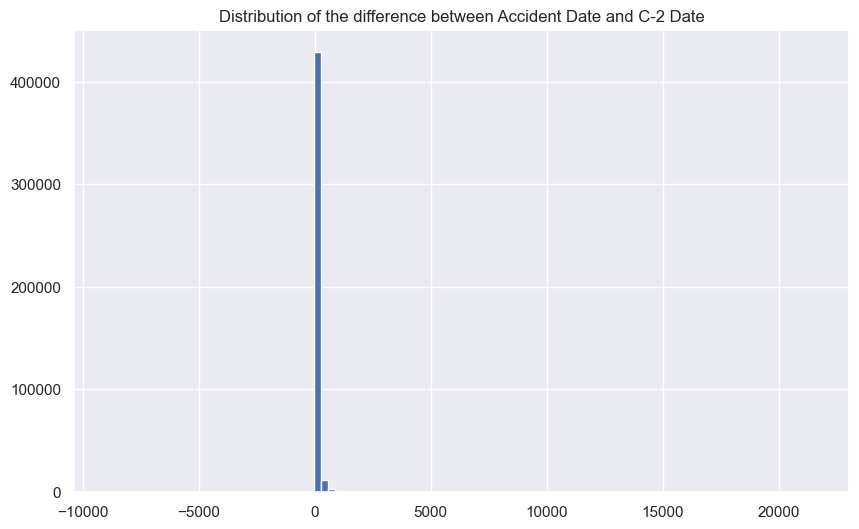

In [50]:
# C-2 Date

# We can assign new dates for NaT for C2-Date columns. Let's first check how does the C-2 Date looks like compared to Accident Date.

# Calculate the difference between Accident Date and C-2 Date
train_data_copy_date = train_data.copy()
train_data_copy_date['Accident_C2_Difference'] = (train_data_copy_date['C-2 Date'] - train_data_copy_date['Accident Date']).dt.days

# Plot the distribution of the difference between Accident Date and C-2 Date
plt.figure(figsize=(10, 6))
plt.hist(train_data_copy_date['Accident_C2_Difference'], bins=100)
plt.title('Distribution of the difference between Accident Date and C-2 Date')

# Describe the difference between Accident Date and C-2 Date
train_data_copy_date['Accident_C2_Difference'].describe()
train_data_copy_date['Accident_C2_Difference'].median()


### We see that median for difference between Accident Date and C-2 Date is 10. We can fill the missing values with accident date + 10 days.

In [51]:
# Fill missing values in C2-Date with Accident Date + 10 days
train_data['C-2 Date'] = train_data['C-2 Date'].fillna(train_data['Accident Date'] + pd.Timedelta(days=10))

print(train_data[['C-2 Date']].isnull().sum())

C-2 Date    0
dtype: int64


In [52]:
# Drop C-3 Date and First Hearing Date columns

# C-3 Date and First Hearing Date columns will be dropped.
train_data.drop(columns=['C-3 Date', 'First Hearing Date'], inplace=True)

In [53]:
non_metric_cols.remove('C-3 Date')
non_metric_cols.remove('First Hearing Date')

In [54]:
print(len(train_data[train_data['C-2 Date'] < train_data['Accident Date']]))

802


## We noticed that in C-2 Date there are 85 (779?) rows with C-2 Date before than Accident Date. We will also fill these with Accident Date + 10 days as we assume that they are errorous rows, since C-2 Date can not be before the Accident Date.

In [55]:
# We also noticed that in C-2 Date there are 85 (779?) rows with C-2 Date before than Accident Date. We will also fill these with Accident Date + 10 days.
train_data.loc[train_data['C-2 Date'] < train_data['Accident Date'], 'C-2 Date'] = train_data['Accident Date'] + pd.Timedelta(days=10)

# Data Preprocessing: Incoherent Values

In [56]:
# 2. Incoherent Values

# We have some assembly dates that are earlier than the accident date. We will drop these rows.
# Rows where 'Assembly Date' is earlier than 'Accident Date'
invalid_dates = train_data[train_data['Assembly Date'] < train_data['Accident Date']]
len(invalid_dates) # -> 1129 rows were spotted

1133

In [57]:
train_data.drop(invalid_dates.index, inplace=True)

# Check for missing values again and length of data
print(((train_data.isnull().sum() / len(train_data)) * 100).sort_values(ascending=False))
print(len(train_data))

Accident Date                        0.0
IME-4 Count                          0.0
WCB Decision                         0.0
Agreement Reached                    0.0
Zip Code                             0.0
WCIO Part Of Body Description        0.0
WCIO Part Of Body Code               0.0
WCIO Nature of Injury Description    0.0
WCIO Nature of Injury Code           0.0
WCIO Cause of Injury Description     0.0
WCIO Cause of Injury Code            0.0
Medical Fee Region                   0.0
Industry Code Description            0.0
Industry Code                        0.0
Gender                               0.0
Age at Injury                        0.0
District Name                        0.0
COVID-19 Indicator                   0.0
County of Injury                     0.0
Claim Injury Type                    0.0
Carrier Type                         0.0
Carrier Name                         0.0
C-2 Date                             0.0
Birth Year                           0.0
Average Weekly W

# Data Preprocessing: Outliers

### Age at Injury:

We decided to create a treshold for the age in dataset

* Age minimum 14, since that is the legal lowest age for working in New York.
* Age maximum 75.
    * First we checked the amount of people in older age brakcets and saw that there were only 1903 people older than 75.
    * We also saw that there were many people still over 64 (legal retirement age) so we decided to push the limit higher than 64.
    * We believe that, although not supported by data, a higher age may correlate with an increased risk of injury. Therefore, we chose not to heavily factor this into our model.

In [58]:
# 3. Outliers

# Create thresholds for Age at Injury.

# Check amount of people who are older than 80
print(len(train_data[train_data['Age at Injury'] > 75]))

# Delete rows with Age at Injury over 75 and under 14
train_data = train_data[(train_data['Age at Injury'] >= 14) & (train_data['Age at Injury'] <= 75)]

1928


In [59]:
# 3. Outliers

# Check the length of the data
print(len(train_data))

# Check for max and min values in Birth Year
print(train_data['Birth Year'].min())
print(train_data['Birth Year'].max())

# We noticed that the lowest value in Birth Year is 0. We will fill the zeros similarly to null values for this column.
train_data.loc[train_data["Birth Year"] == 0, "Birth Year"] = train_data["Accident Date"].dt.year - train_data["Age at Injury"]

# Check for max and min values in Birth Year
print(train_data['Birth Year'].min())
print(train_data['Birth Year'].max())

# Check for maximum difference between age at injury and birth year. (Gap should be between -1 and 1 for valid data since some people may have had their birthday after/before the accident)
print((train_data['Accident Date'].dt.year - train_data['Birth Year'] - train_data['Age at Injury']).max())
print((train_data['Accident Date'].dt.year - train_data['Birth Year'] - train_data['Age at Injury']).min())

451721
0
2008
1920
2008
1
-1


### Identifying outliers from numeric columns with histograms and boxplots

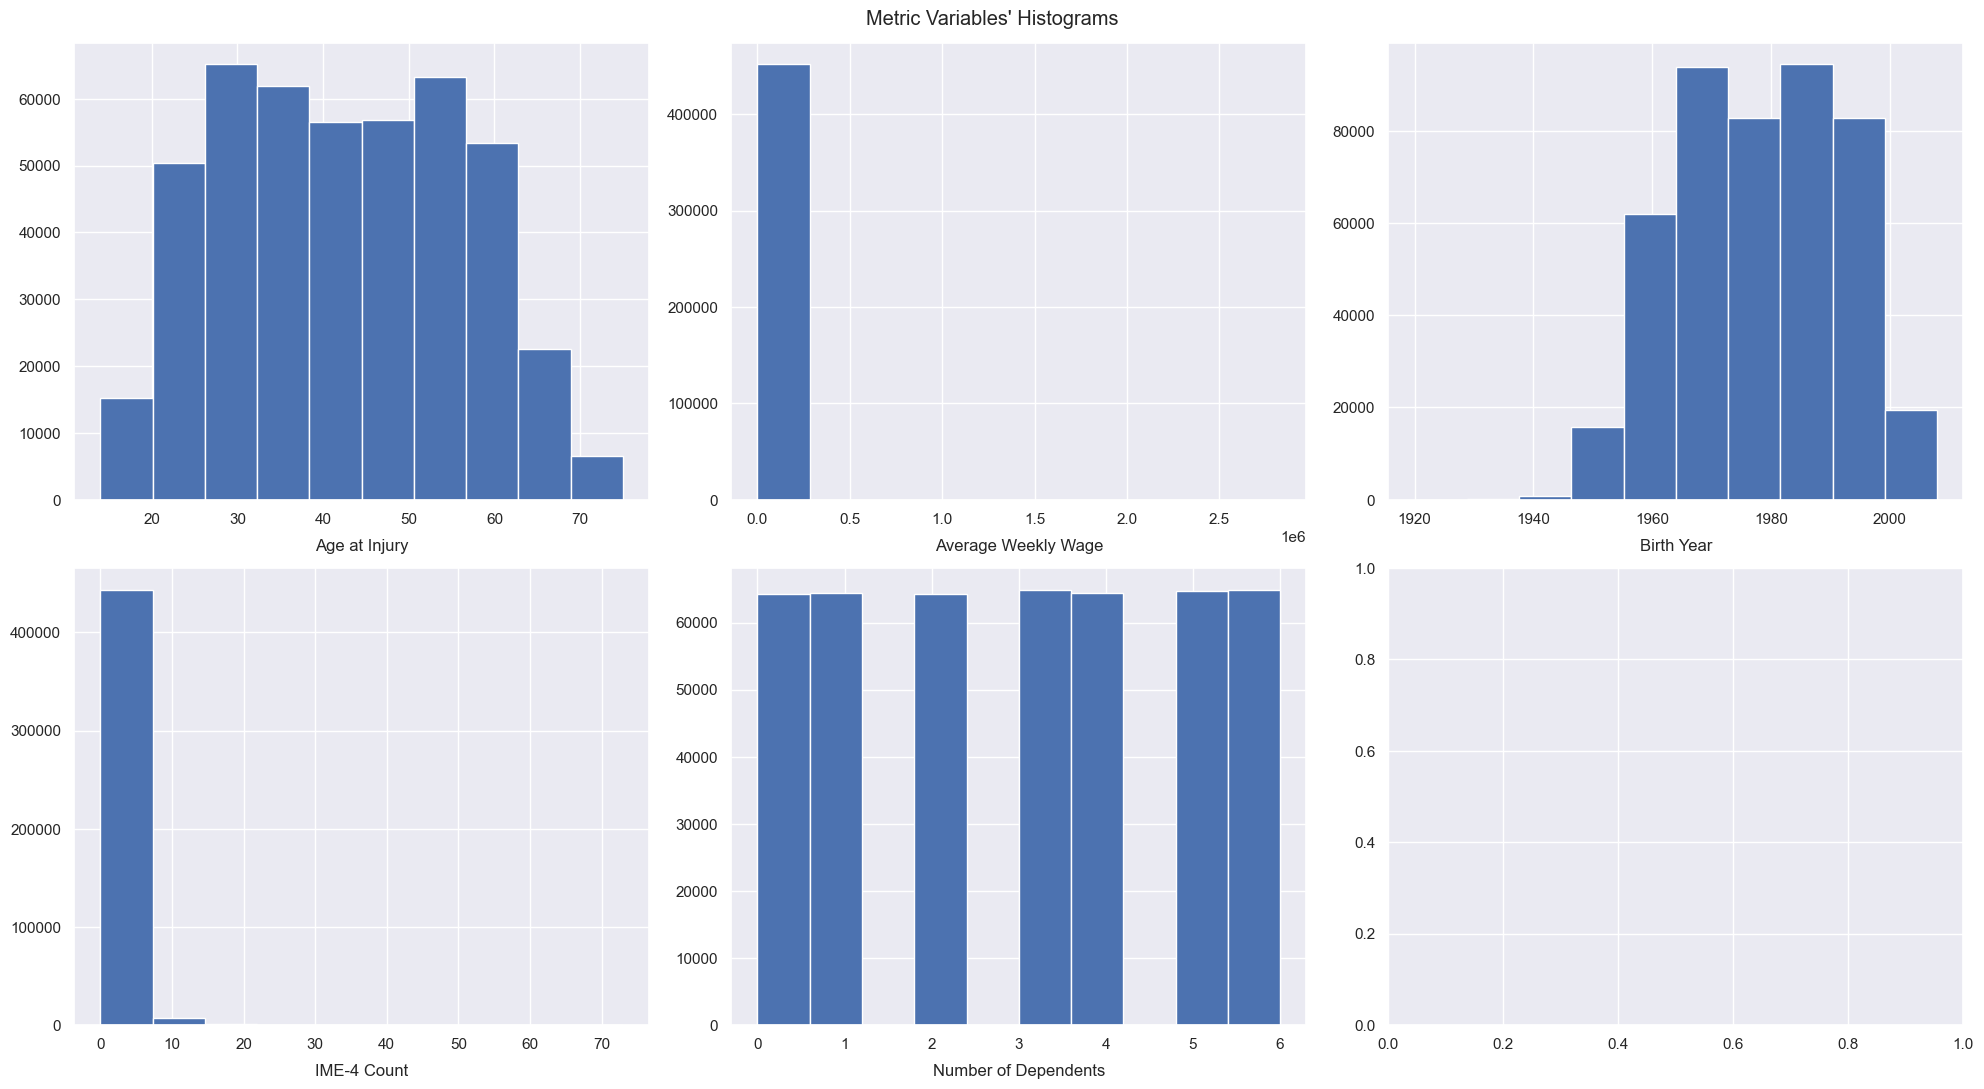

In [60]:
# 3. Outliers

# Check for outliers in the numeric columns

# Using boxplot and historgams to identify outliers

#Histogram
# Plot all Numeric Variables' Histograms in one figure
sns.set() ## Reset to darkgrid

# Prepare figure. Create individual axes where each histogram will be placed
sp_rows = 2
sp_cols = ceil(len(metric_cols) / sp_rows) 


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                        tight_layout=True)

# Plot data
# Iterate across axes objects and associate each histogram
for ax, feat in zip(axes.flatten(), metric_cols): 
    ax.hist(train_data[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Histograms"

plt.suptitle(title)

plt.show()


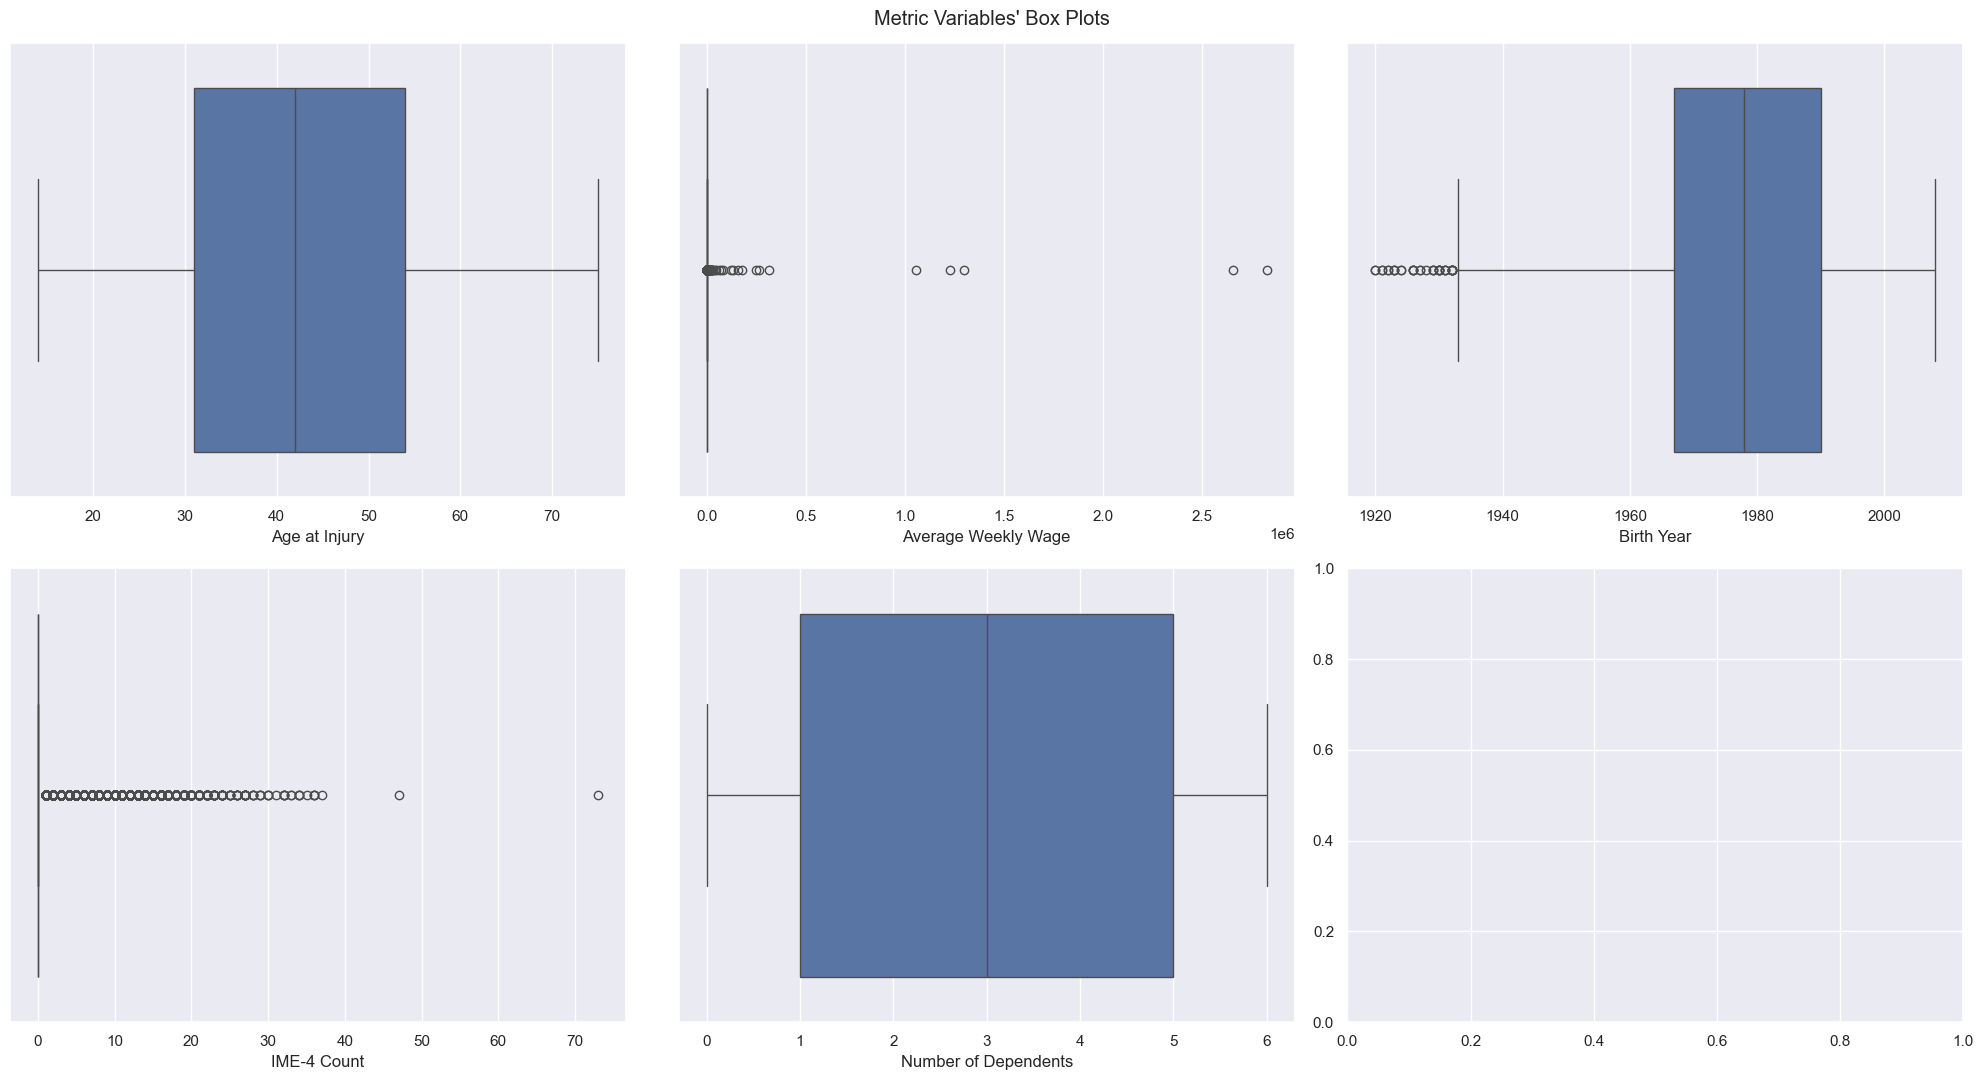

In [61]:
# Boxplots

# Plot ALL Numeric Variables' Boxplots in one figure

sns.set() ## Reset to darkgrid

sp_rows = 2
sp_cols = ceil(len(metric_cols) / sp_rows)


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                         tight_layout=True
                        )

# Plot data
# Iterate across axes objects and associate each histogram 
for ax, feat in zip(axes.flatten(), metric_cols): 
    sns.boxplot(x=train_data[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Box Plots"

plt.suptitle(title)

plt.show()

#### We want to keep track of the amount of dropped data regularly through the outlier handling

In [62]:
# Check the amount of data dropped this far
original_length = 474776

print(original_length)
print(len(train_data))

dropped = (1-(len(train_data)/original_length))*100

print(dropped, " % of the data was dropped.")

474776
451721
4.8559741857212675  % of the data was dropped.


### Let's go through the outliers in the metric data column by column

In [63]:
# 3. Outliers

# Age at Injury
"""
Outliers are already handled by the age limits set earlier.
"""

'\nOutliers are already handled by the age limits set earlier.\n'

#### Average weekly wage

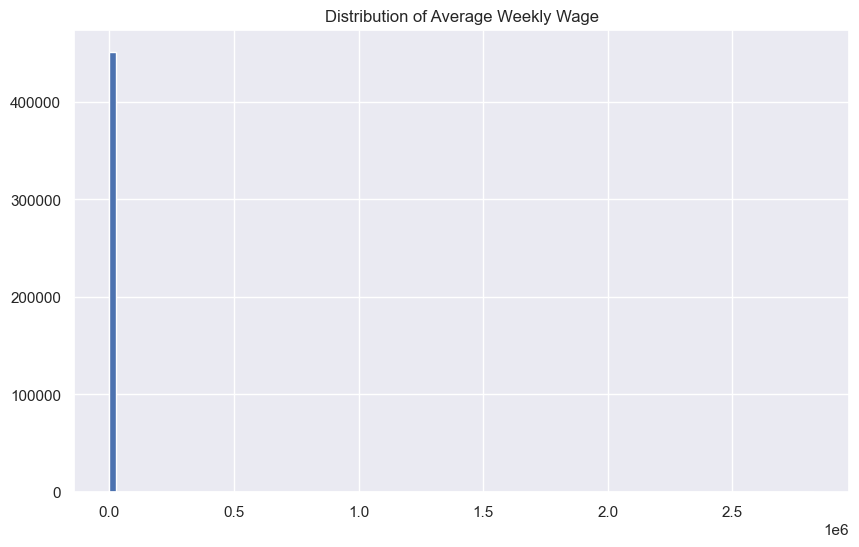

In [64]:
# 3. Outliers

# Plot the distribution of the Average Weekly Wage column
plt.figure(figsize=(10, 6))
plt.hist(train_data['Average Weekly Wage'], bins=100)
plt.title('Distribution of Average Weekly Wage')
plt.show()


In [65]:
# Check the amount of zero values in Average Weekly Wage
print(len(train_data[train_data['Average Weekly Wage'] == 0]))

# Check the percentage of zero values in data
zero_percentage = (len(train_data[train_data['Average Weekly Wage'] == 0]) / len(train_data)) * 100
print("Percentage of zero values in data", zero_percentage)

263005
Percentage of zero values in data 58.222885365081545


## Average Weekly Wage Assumption: 58% of the data is zeros: We Assume that the zeroes are missing values and we fill zeroes with median wage of the industry the row has

In [66]:
# Impute the zero values with the median of the industry

# The median mapping for the Average Weekly Wage column
mean_wage_mapping
print(mean_wage_mapping)

# Fill the zero values in the Average Weekly Wage column with the median of the industry
train_data['Average Weekly Wage'] = train_data.apply(lambda row: mean_wage_mapping[row['Industry Code']] if row['Average Weekly Wage'] == 0 else row['Average Weekly Wage'], axis=1)

# Check the amount of zero values in Average Weekly Wage
print(len(train_data[train_data['Average Weekly Wage'] == 0]))


{0: 34.42, 11: 363.04, 21: 515.92, 22: 1098.27, 23: 790.63, 31: 410.95, 32: 403.69, 33: 442.37, 42: 476.81, 44: 234.44, 45: 258.77, 48: 669.34, 49: 572.64, 51: 1050.7, 52: 374.59, 53: 486.56, 54: 281.44, 55: 339.69, 56: 381.23, 61: 286.64, 62: 454.41, 71: 310.41, 72: 228.85, 81: 356.2, 92: 831.3}
0


In [67]:
# Check distribution of the Average Weekly Wage column after imputation 
train_data['Average Weekly Wage'].describe().round(2)

count     451721.00
mean         768.26
std         6631.76
min           13.94
25%          363.04
50%          501.35
75%          844.20
max      2828079.00
Name: Average Weekly Wage, dtype: float64

In [68]:
# Check amount of outliers after zero-value handling
# Check the distribution of the Average Weekly Wage column and amount of outliers with z-score method and IQR method

# Calculate z-scores for Average Weekly Wage
z_scores = stats.zscore(train_data['Average Weekly Wage'])

# Find the indices of the outliers
outliers = np.where(np.abs(z_scores) > 3)

# Check the amount of outliers
print(len(outliers[0]))

# Check the percentage of outliers in data
outliers_percentage = (len(outliers[0]) / len(train_data)) * 100
print("Percentage of outliers in data with z-score method", outliers_percentage)


# Check the amount of outliers with IQR method
Q1 = train_data['Average Weekly Wage'].quantile(0.25)
Q3 = train_data['Average Weekly Wage'].quantile(0.75)

IQR = Q3 - Q1

# Find the indices of the outliers
outliers = train_data[(train_data['Average Weekly Wage'] < (Q1 - 1.5 * IQR)) | (train_data['Average Weekly Wage'] > (Q3 + 1.5 * IQR))]

# Check the amount of outliers
print(len(outliers))

# Check the percentage of outliers in data
outliers_percentage = (len(outliers) / len(train_data)) * 100
print("Percentage of outliers in data with IQR method", outliers_percentage)

# See min and max values for Average Weekly Wage for non-outlier data for both methods

# Z-score method
non_outliers_z = train_data[(np.abs(z_scores) <= 3)]
print(non_outliers_z['Average Weekly Wage'].min())
print(non_outliers_z['Average Weekly Wage'].max())

# IQR method
non_outliers_iqr = train_data[(train_data['Average Weekly Wage'] >= (Q1 - 1.5 * IQR)) & (train_data['Average Weekly Wage'] <= (Q3 + 1.5 * IQR))]
print(non_outliers_iqr['Average Weekly Wage'].min())
print(non_outliers_iqr['Average Weekly Wage'].max())

24
Percentage of outliers in data with z-score method 0.005313014006433175
41973
Percentage of outliers in data with IQR method 9.291797370500818
13.94
20280.72
13.94
1565.92


In [69]:
# Delete the outliers with z-score method
train_data = train_data[(np.abs(z_scores) <= 3)]

# Check the amount of data dropped this far
print(original_length)
print(len(train_data))

dropped = (1-(len(train_data)/original_length))*100

print(dropped, " % of the data was dropped.")

474776
451697
4.861029201139067  % of the data was dropped.


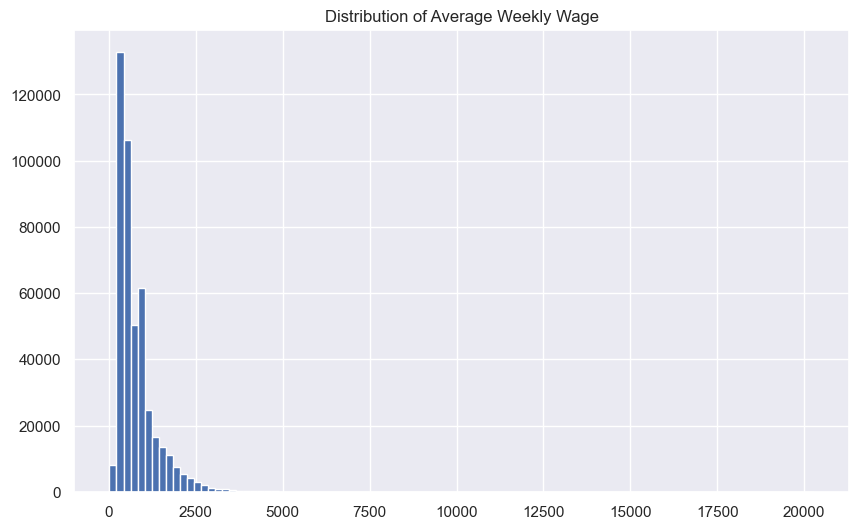

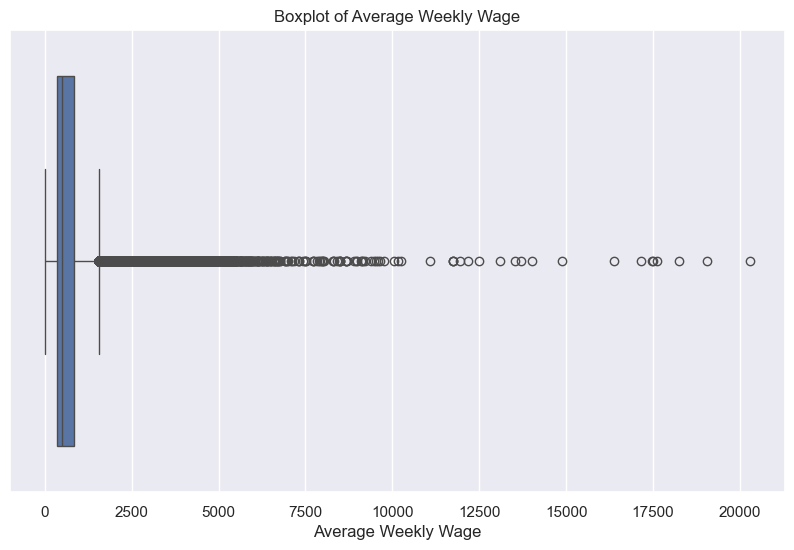

In [70]:
# Check the distribution of the Average Weekly Wage column again after outlier handling
plt.figure(figsize=(10, 6))
plt.hist(train_data['Average Weekly Wage'], bins=100)
plt.title('Distribution of Average Weekly Wage')
plt.show()

# Check the boxplot of the Average Weekly Wage column after outlier handling
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['Average Weekly Wage'])
plt.title('Boxplot of Average Weekly Wage')
plt.show()

#### For Birth year, we decided to get the outliers with IQR method. Data points outside the range [Q1-1.5xIQR Q3+1.5xIQR] were dropped

In [71]:
# 3. Outliers

# Birth Year
"""
Birth year has outliers below lower whisker. We will drop these rows.
"""

# Get the outliers in Birth Year with IQR method
Q1 = train_data['Birth Year'].quantile(0.25)
Q3 = train_data['Birth Year'].quantile(0.75)
IQR = Q3 - Q1

# Get the indexes of the outliers
outliers_birth_year = train_data[(train_data['Birth Year'] < (Q1 - 1.5 * IQR)) | (train_data['Birth Year'] > (Q3 + 1.5 * IQR))]
# See the range of the outliers Birth Year
print(outliers_birth_year['Birth Year'].min())
print(outliers_birth_year['Birth Year'].max())

# Drop the outliers
train_data.drop(outliers_birth_year.index, inplace=True)
print(len(train_data))

dropped = (1-(len(train_data)/original_length))*100
print(dropped, " % of the data was dropped.")

1920
1932
451661
4.868611724265759  % of the data was dropped.


#### Number of Dependents doesn't have outliers

In [72]:
# Number of Dependents
print(train_data['Number of Dependents'].max())
print(train_data['Number of Dependents'].min())
"""
Number of Dependents doesn't have outliers so we are fine
"""

6.0
0.0


"\nNumber of Dependents doesn't have outliers so we are fine\n"

### IME-4 Count
* We noticed that the IQR is 0 and amount of outliers is over 104633 rows with IQR method. We tried z-score method.
* We noticed that z-score gives more appropriate amount of outliers and more reasonable range of values in outliers.
    * Even with z-score method, the z-score gives us 11230 rows as outliers. We are not comfortable dropping this many rows.
        * Lower limit for threshold value for the variable given by z-score was 7. In our opinion, given the decription of the metadata and the distribution of the data, this threshold is too big to use as criteria for dropping rows.
        * Also the upper limit for threshold given by z-score method is 73 which would be a huge number to include to the data given the description and the distribution.

* We see that amount of outliers is 7086 if we set the upper threshold to 10. 
    * We think that considering metadata and dsitribution of the column this is a reasonable threshold.
        * 10 preserves enough data
        *  Metadata: "Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner's Report of Independent Medical Examination” form."
            * Number higher than 10 seems unusual (and given the distribution of the data, it is rather unusual)


In [73]:
# IME-4 Count
"""
According to the boxplot, there are outliers in IME-4 Count. Let's see how many there are with IQR method
"""

# Get the outliers in IME-4 Count with IQR method
Q1 = train_data['IME-4 Count'].quantile(0.25)
Q3 = train_data['IME-4 Count'].quantile(0.75)
IQR = Q3 - Q1

# Get the indexes of the outliers
outliers_ime_4 = train_data[(train_data['IME-4 Count'] < (Q1 - 1.5 * IQR)) | (train_data['IME-4 Count'] > (Q3 + 1.5 * IQR))]

# See the amount of the outliers IME-4 Count
print(len(outliers_ime_4))

# Chekc the range of the outliers IME-4 Count
print(outliers_ime_4['IME-4 Count'].min())
print(outliers_ime_4['IME-4 Count'].max())

"""
We noticed that the IQR is 0 and amount of outliers is over 130 000 rows with IQR method. We will try z-score method.
"""

# Calculate the z-scores
z_scores = stats.zscore(train_data['IME-4 Count'])

# Get the indexes of the outliers
outliers_ime_4 = train_data[(z_scores < -3) | (z_scores > 3)]
print(len(outliers_ime_4))

# Check the range of the outliers IME-4 Count
print(outliers_ime_4['IME-4 Count'].min())
print(outliers_ime_4['IME-4 Count'].max())

# We noticed that z-score gives more appropriate amount of outliers and more reasonable range of values in outliers.

# See how many rows in outliers_ime_4 has value less than 10
print(len(outliers_ime_4[outliers_ime_4['IME-4 Count'] < 10]))

# We see that amount of outliers is 8838 if we set the threshold to 10. We think that considering metadata of the column this is a reasonable threshold.
# Drop the rows that have IME-4 Count more than 10
train_data = train_data[train_data['IME-4 Count'] <= 10]

# Check the length of the data
print(len(train_data))

dropped = (1-(len(train_data)/original_length))*100
print(dropped, " % of the data was dropped.")

104764
1.0
73.0
11253
7.0
73.0
7052
448626
5.507860548974675  % of the data was dropped.


#### Visualize the boxplots again for numeric columns.

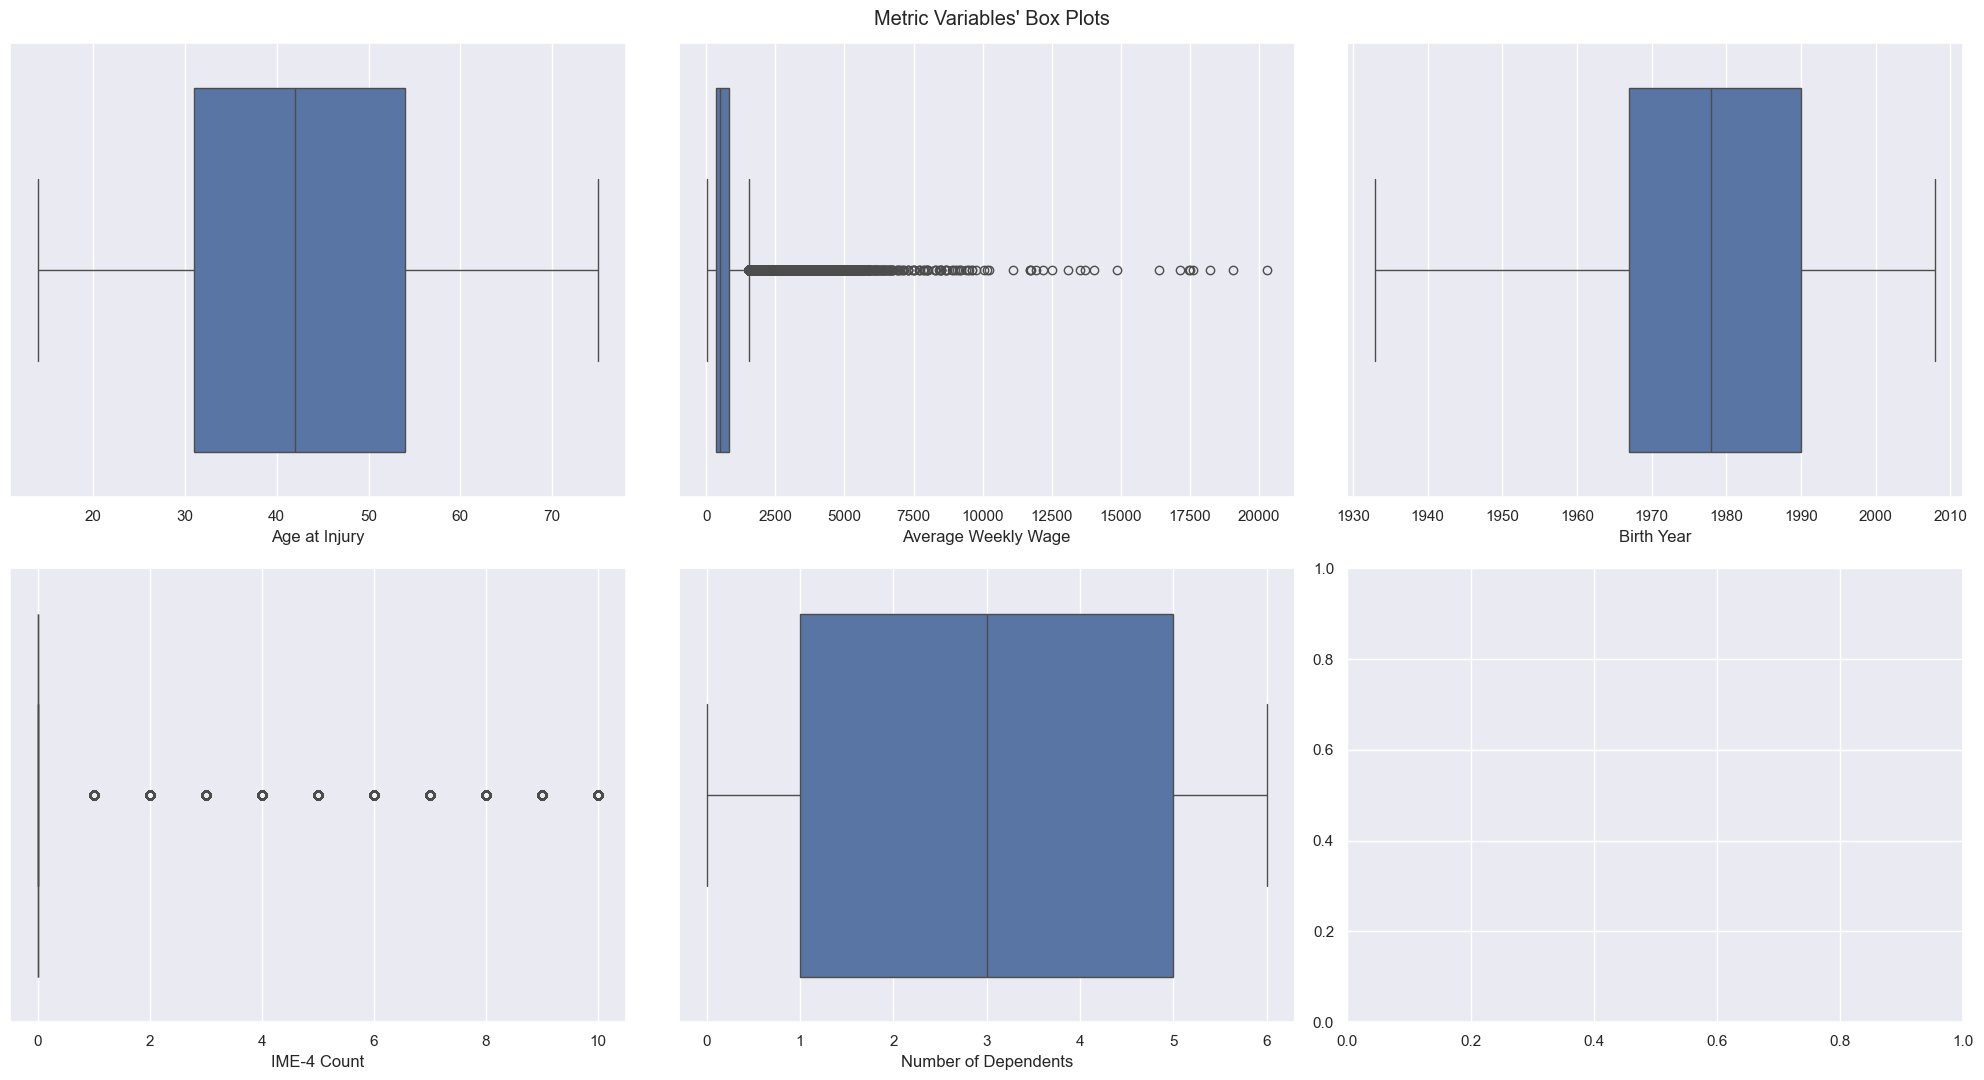

In [74]:
# Plot ALL Numeric Variables' Boxplots in one figure

sns.set() ## Reset to darkgrid

sp_rows = 2
sp_cols = ceil(len(metric_cols) / sp_rows)


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                         tight_layout=True
                        )

# Plot data
# Iterate across axes objects and associate each histogram 
for ax, feat in zip(axes.flatten(), metric_cols): 
    sns.boxplot(x=train_data[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Box Plots"

plt.suptitle(title)

plt.show()

## Data Preprocessing: Outliers for non-numeric columns.

#### Instead of visual inspection, we will use the value_counts() method to identify outliers in the non-numeric columns.

In [75]:
# 3. Data cleaning -Outliers

# Check for outliers in the non-numeric columns 

# Get dates out of non-metric columns for visualisation
non_metric_cols_no_dates = [col for col in non_metric_cols if col not in ['Accident Date', 'Assembly Date', 'C-2 Date']]

# Give the value counts for the non-numeric columns
for col in non_metric_cols_no_dates:
    print(train_data[col].value_counts(normalize=True, dropna=False))

Alternative Dispute Resolution
False    0.995466
True     0.004534
Name: proportion, dtype: float64
Attorney/Representative
False    0.69241
True     0.30759
Name: proportion, dtype: Float64
Carrier Name
STATE INSURANCE FUND            0.194478
POLICE, FIRE, SANITATION        0.038067
AMERICAN ZURICH INSURANCE CO    0.030306
CHARTER OAK FIRE INS CO         0.030081
INDEMNITY INS. OF N AMERICA     0.025041
                                  ...   
EAST QUOQUE UFSD                0.000002
SCHENEVUS CSD                   0.000002
HERMON-DEKALB CENTRAL           0.000002
ARROWOOD INDEMNITY CO           0.000002
ARI INSURANCE COMPANY           0.000002
Name: proportion, Length: 1992, dtype: float64
Carrier Type
1A. PRIVATE                                    0.495740
3A. SELF PUBLIC                                0.212883
2A. SIF                                        0.194478
4A. SELF PRIVATE                               0.092346
UNKNOWN                                        0.002833
5D. S

#####  Alternative Dispute resolution
* 99.5 % of the data is 'False'. We will drop this column since it barely has any True values.

In [76]:
# Alternnative Dispute resolution
"""
99.5 % of the data is 'False'. We will drop this column since it barely has any True values.
"""

# Drop the Alternative Dispute Resolution column
train_data.drop(columns=['Alternative Dispute Resolution'], inplace=True)
non_metric_cols.remove('Alternative Dispute Resolution')

#### Attorney/Representative is OK when it comes to outliers

In [77]:
# Attorney/Representative OK


#### We will analyze the correlation between Carrier Name and Carrier Type because we assume they represent the same thing in different ways.

In [78]:

# We will analyze the correlation between Carrier Name and Carrier Type because we assume they represent the same thing in different ways.
contingency_table = pd.crosstab(train_data['Carrier Type'], train_data['Carrier Name'])


chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("Cramér's V:", cramers_v)


Cramér's V: 0.9635274641378345


### As we can see, the correlation between Carrier Name and Carrier Type is very high. We will drop Carrier Name column.

In [79]:

# Drop the Carrier Name column
train_data.drop(columns=['Carrier Name'], inplace=True)
non_metric_cols.remove('Carrier Name')

### WCIO Nature of Injury Code, WCIO Part Of Body Code, WCIO Part Of Body Description and WCIO Part Of Body Code
* All the description columns can be dropped since they are just descriptions of the codes.
* Before dropping the columns, we will check that the codes are unique for each description (everywhere else than Industry Code since there mulitple codes can mean same descriptions)


In [80]:
# Check if the codes are unique for each description
print(train_data['WCIO Nature of Injury Code'].nunique() == train_data['WCIO Nature of Injury Description'].nunique())
# True so we are OK to drop without extra handling

print(train_data['WCIO Part Of Body Code'].nunique() == train_data['WCIO Part Of Body Description'].nunique())
# False so we need to handle this

# See amount of unique values in WCIO Part Of Body Description
print(train_data['WCIO Part Of Body Description'].nunique())

# See amount of unique values in WCIO Part Of Body Code
print(train_data['WCIO Part Of Body Code'].nunique())

# Find all unique pairs of WCIO Part Of Body Code and WCIO Part Of Body Description
# Make a copy of the data
train_data_copy = train_data.copy()
unique_pairs = train_data_copy[['WCIO Part Of Body Code', 'WCIO Part Of Body Description']].drop_duplicates()

# See the codes that have the same code but different descriptions
print(unique_pairs['WCIO Part Of Body Description'].value_counts().sort_values(ascending=False))



True
False
55
58
WCIO Part Of Body Description
SPINAL CORD                                              2
DISC                                                     2
SOFT TISSUE                                              2
FINGER(S)                                                1
LOWER BACK AREA                                          1
LOWER ARM                                                1
MULTIPLE                                                 1
FACIAL BONES                                             1
SHOULDER(S)                                              1
LOWER LEG                                                1
INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED    1
FOOT                                                     1
MULTIPLE LOWER EXTREMITIES                               1
SKULL                                                    1
ANKLE                                                    1
THUMB                                                    1
MOUTH    

#### We found that Description DISC, SPINAL CORD and SOFT TISSUE have same Descriptions for different codes. We Checked from metadata that these descriptions indeed have different codes. We are OK to drop this description columns.

In [81]:

print(train_data['WCIO Cause of Injury Code'].nunique() == train_data['WCIO Cause of Injury Description'].nunique())

# See amount of unique values in WCIO Part Of Body Description
print(train_data['WCIO Cause of Injury Code'].nunique())

# See amount of unique values in WCIO Part Of Body Code
print(train_data['WCIO Cause of Injury Description'].nunique())

# Find all unique pairs of WCIO Cause of Injury Code and WCIO Cause of Injury Description
# Make a copy of the data
train_data_copy = train_data.copy()
unique_pairs = train_data_copy[['WCIO Cause of Injury Code', 'WCIO Cause of Injury Description']].drop_duplicates()

# See the codes that have the same code but different descriptions
print(unique_pairs['WCIO Cause of Injury Description'].value_counts().sort_values(ascending=False))


# Drop the description columns
train_data.drop(columns=['WCIO Part Of Body Description', 'WCIO Nature of Injury Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], inplace=True)
non_metric_cols = [col for col in non_metric_cols if col not in ['WCIO Part Of Body Description', 'WCIO Nature of Injury Description', 'WCIO Cause of Injury Description', 'Industry Code Description']]


False
78
75
WCIO Cause of Injury Description
OBJECT BEING LIFTED OR HANDLED                 3
REPETITIVE MOTION                              2
0. UNKNOWN                                     1
COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE    1
ON ICE OR SNOW                                 1
                                              ..
SANDING, SCRAPING, CLEANING OPERATION          1
WELDING OPERATION                              1
CRASH OF AIRPLANE                              1
STEAM OR HOT FLUIDS                            1
RADIATION                                      1
Name: count, Length: 75, dtype: int64


### We found that Description OBJECT BEING LIFTED OR HANDLED and REPETITIVE MOTION have same Descriptions for different codes.
* We Chekced from metadata that these descriptions indeed have different codes. 
* For REPETITIVE MOTION, we didn't find any information about the code. We will assume that this is OK since all the other descriptions with non-unique codes were OK as well
* We are OK to drop this description columns.

In [82]:
# Check again the value counts for the non-numeric columns

non_metric_cols_no_dates = [col for col in non_metric_cols if col not in ['Accident Date', 'Assembly Date', 'C-2 Date']]
# Give the value counts for the non-numeric columns
for col in non_metric_cols_no_dates:
    print(train_data[col].value_counts(normalize=True, dropna=False))

Attorney/Representative
False    0.69241
True     0.30759
Name: proportion, dtype: Float64
Carrier Type
1A. PRIVATE                                    0.495740
3A. SELF PUBLIC                                0.212883
2A. SIF                                        0.194478
4A. SELF PRIVATE                               0.092346
UNKNOWN                                        0.002833
5D. SPECIAL FUND - UNKNOWN                     0.001710
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)    0.000004
5C. SPECIAL FUND - POI CARRIER WCB MENANDS     0.000004
Name: proportion, dtype: float64
County of Injury
SUFFOLK       0.105235
QUEENS        0.101185
KINGS         0.092676
NASSAU        0.075680
BRONX         0.068770
                ...   
WYOMING       0.001300
MONTGOMERY    0.001072
SCHOHARIE     0.000945
YATES         0.000724
HAMILTON      0.000236
Name: proportion, Length: 63, dtype: float64
COVID-19 Indicator
False    0.951369
True     0.048631
Name: proportion, dtype: float64
District Nam

### County of Injury, District Name, Medical Fee Region and ZIP Code
Metadata:
- ZIP Code is home address of the injured person.
- County of Injury is the name of NY county where the injury happened.
- District Name is name of WCB district office that oversees the area that the injury happened.
- Medical Fee Region is the approx. region where the medical treatment was given.


#### From Metadata we can assume that at least County of Injury and District Name essentially represent the same thing. (Same county of injury usually will have the same district office)
* We will check the correlations between these columns with Cramer's V.

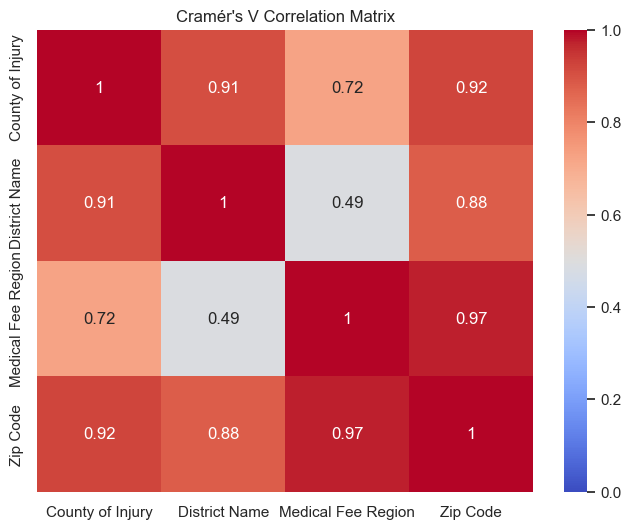

In [83]:
# County of Injury, District Name, Medical Fee Region and ZIP Code

"""
- ZIP Code is home address of the injured person.
- County of Injury is the name of NY county where the injury happened.
- District Name is name of WCB district office that oversees the area that the injury happened.
- Medical Fee Region is the approx. region where the medical treatment was given.

From Metadata we can assume that at least County of Injury and District Name essentially represent the same thing. (Same county of injury usually will have the same district office)

We will check the correlations between these columns with Cramer's V.
"""

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    
    chi2, _, _, _ = stats.chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

columns = ["County of Injury", "District Name", "Medical Fee Region", "Zip Code"]

cramers_v_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), 
                                index=columns, 
                                columns=columns)


for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            cramers_v_matrix.loc[col1, col2] = cramers_v(train_data[col1], train_data[col2])
        else:
            cramers_v_matrix.loc[col1, col2] = 1 

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Matrix")
plt.show()


* We can see from the cramer's v matrix that County of Injury has very high correlation with District Name and Zip Code.
* We can also see that Zip Code has very high correlation with County of Injury and District Name and Medical Fee Region.
* Only non-highly correlated columns are District Name and Medical Fee Region.

Conclusion:
* We will drop County of Injury and Zip Code columns.

In [84]:
# We will drop County of Injury and Zip Code columns.
train_data.drop(columns=['County of Injury', 'Zip Code'], inplace=True)
non_metric_cols = [col for col in non_metric_cols if col not in ['County of Injury', 'Zip Code']]

In [85]:
# Check again the value counts for the non-numeric columns

non_metric_cols_no_dates = [col for col in non_metric_cols if col not in ['Accident Date', 'Assembly Date', 'C-2 Date']]
# Give the value counts for the non-numeric columns
for col in non_metric_cols_no_dates:
    print(train_data[col].value_counts(normalize=True, dropna=False))

Attorney/Representative
False    0.69241
True     0.30759
Name: proportion, dtype: Float64
Carrier Type
1A. PRIVATE                                    0.495740
3A. SELF PUBLIC                                0.212883
2A. SIF                                        0.194478
4A. SELF PRIVATE                               0.092346
UNKNOWN                                        0.002833
5D. SPECIAL FUND - UNKNOWN                     0.001710
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)    0.000004
5C. SPECIAL FUND - POI CARRIER WCB MENANDS     0.000004
Name: proportion, dtype: float64
COVID-19 Indicator
False    0.951369
True     0.048631
Name: proportion, dtype: float64
District Name
NYC           0.470448
ALBANY        0.150591
HAUPPAUGE     0.105464
BUFFALO       0.079264
SYRACUSE      0.078061
ROCHESTER     0.071077
BINGHAMTON    0.038669
STATEWIDE     0.006426
Name: proportion, dtype: float64
Gender
M    0.582044
F    0.409720
U    0.008154
X    0.000082
Name: proportion, dtype: float64


#### Covid-19 Indicator

In [86]:
# Covid-19 Indicator

# Check the correlation between COVID-19 Indicator and WCIO Nature of Injury Code
contingency_table = pd.crosstab(train_data['COVID-19 Indicator'], train_data['WCIO Nature of Injury Code'])

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("Cramér's V:", cramers_v)

# We can see that the correlation between COVID-19 Indicator and WCIO Cause of Injury Code is very high. We will drop COVID-19 Indicator column.

# Drop the COVID-19 Indicator column
train_data.drop(columns=['COVID-19 Indicator'], inplace=True)
non_metric_cols.remove('COVID-19 Indicator')

Cramér's V: 0.9658198932254409


Covid-19 Indicator
* We can see that we have True only in 4.8% of the data. 
* We found that in WCIO Cause of Injury Code, code 83 is for COVID-19. That means that we could represent the COVID-19 Indicator with this column.
* We can see that the correlation between COVID-19 Indicator and WCIO Cause of Injury Code is very high. We will drop COVID-19 Indicator column.


#### Gender

In [87]:
# Check amount of data for rows with other than M and F
print(train_data['Gender'].value_counts())
train_data['Gender'].value_counts(normalize=True)

# Drop rows with other than M and F
train_data = train_data[train_data['Gender'].isin(['M', 'F'])]

print(len(train_data))

dropped = (1-(len(train_data)/original_length))*100
print(dropped, " % of the data is dropped.")

Gender
M    261120
F    183811
U      3658
X        37
Name: count, dtype: int64
444931
6.2861222976730025  % of the data is dropped.


* Gender: We can see that we have only less than 0.1% of the data with other than M and F. We will drop these rows.

# About the target variable
- Our target varibale in first deliverable is Claim Injury Type
- For now WCB Decision and Agreement Reached are not consideres as features, but later in project we will use them as target variables.
    - We will exclude them from columns

#### See target value class imbalances

In [88]:
# Data Class Imbalances

# Check for class imbalances in the target value
print(train_data['Claim Injury Type'].value_counts(normalize=True))

# exclude the WCB Decision column and Agreement Reached column from the train data
train_data.drop(columns=['WCB Decision', 'Agreement Reached'], inplace=True)
non_metric_cols = [col for col in non_metric_cols if col not in ['WCB Decision', 'Agreement Reached']]


Claim Injury Type
2. NON-COMP        0.510194
4. TEMPORARY       0.257038
3. MED ONLY        0.121421
5. PPD SCH LOSS    0.084456
1. CANCELLED       0.018882
6. PPD NSL         0.007107
8. DEATH           0.000769
7. PTD             0.000135
Name: proportion, dtype: float64


### We can see that the target variable has some categories that only appear less than 1% of the data. Keep this in mind in model training. (Oversampling, undersampling or SMOTE probably needed)

In [89]:
# Let see all the columns that we have left
print(train_data.columns)
print(len(train_data.columns))

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'C-2 Date', 'Carrier Type', 'Claim Injury Type', 'District Name',
       'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Number of Dependents'],
      dtype='object')
18


# Feature engineering

## Creation of new features

### Time Until Injury Reported: Difference between Accident Date and Assembly Date

#### Very interesting feature that could potentially have an impact on the target variable, assuming that faster reported accidents might have a higher chance of being accepted

In [90]:
# Time Until Injury Reported: Difference between Accident Date and Assembly Date

# Calculate the difference between Accident Date and Assembly Date
train_data['Days Until Injury Reported'] = (train_data['Assembly Date'] - train_data['Accident Date']).dt.days

# Append the new column to the metric columns
metric_cols.append('Days Until Injury Reported')

# Check the dtype of the new column
print(train_data['Days Until Injury Reported'].dtype)

int64


#### See the distribution of the Days Until Injury Reported and handle possible outliers

Text(0.5, 1.0, 'Boxplot of the Days Until Injury Reported, before outlier handling')

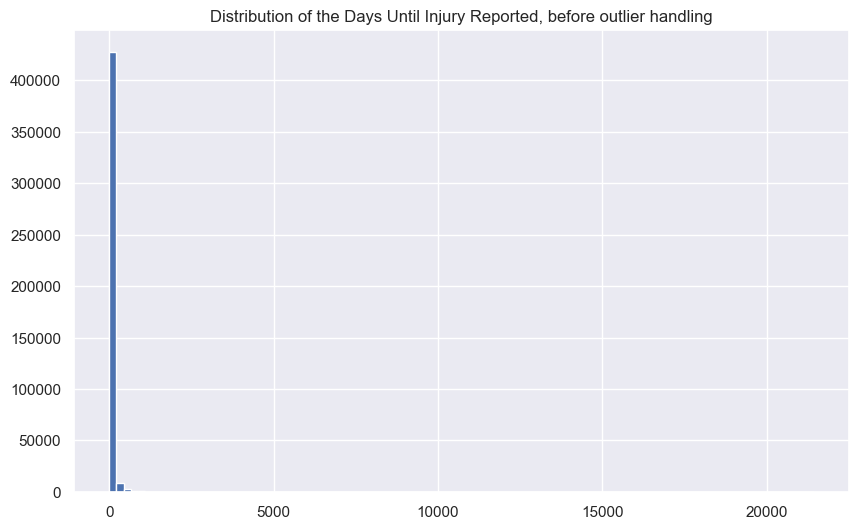

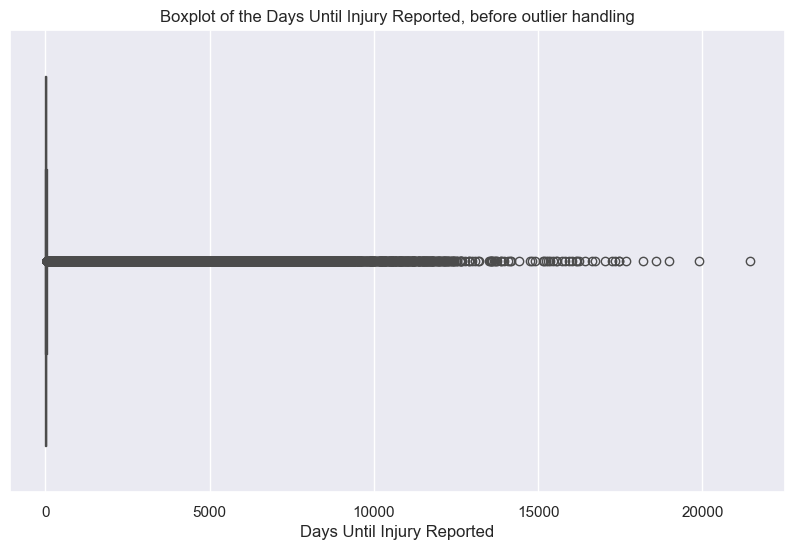

In [91]:
# See the distribution of the Days Until Injury Reported
plt.figure(figsize=(10, 6))
plt.hist(train_data['Days Until Injury Reported'], bins=100)
plt.title('Distribution of the Days Until Injury Reported, before outlier handling')

# Check for outliers in the Days Until Injury Reported column with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['Days Until Injury Reported'])
plt.title('Boxplot of the Days Until Injury Reported, before outlier handling')


In [92]:

# Check the descriptive statistics of the Days Until Injury Reported column
train_data['Days Until Injury Reported'].describe()

# Calculate the z-scores
z_scores = stats.zscore(train_data['Days Until Injury Reported'])

# Get the indexes of the outliers
outliers_days_until_injury_reported = train_data[(z_scores < -3) | (z_scores > 3)]

print(len(outliers_days_until_injury_reported))

# Check the range of the outliers Days Until Injury Reported
print(outliers_days_until_injury_reported['Days Until Injury Reported'].min())
print(outliers_days_until_injury_reported['Days Until Injury Reported'].max())


# Check the claim injury type for the outliers (to see that we are not deleting only one type of claim injury type)
print(outliers_days_until_injury_reported['Claim Injury Type'].value_counts())

# Drop the outliers
train_data.drop(outliers_days_until_injury_reported.index, inplace=True)

3428
1759
21439
Claim Injury Type
4. TEMPORARY       1567
2. NON-COMP        1201
1. CANCELLED        352
3. MED ONLY         197
5. PPD SCH LOSS     103
6. PPD NSL            7
7. PTD                1
Name: count, dtype: int64


#### See the histogram and boxplot again after outlier handling

Text(0.5, 1.0, 'Boxplot of the Days Until Injury Reported, before outlier handling')

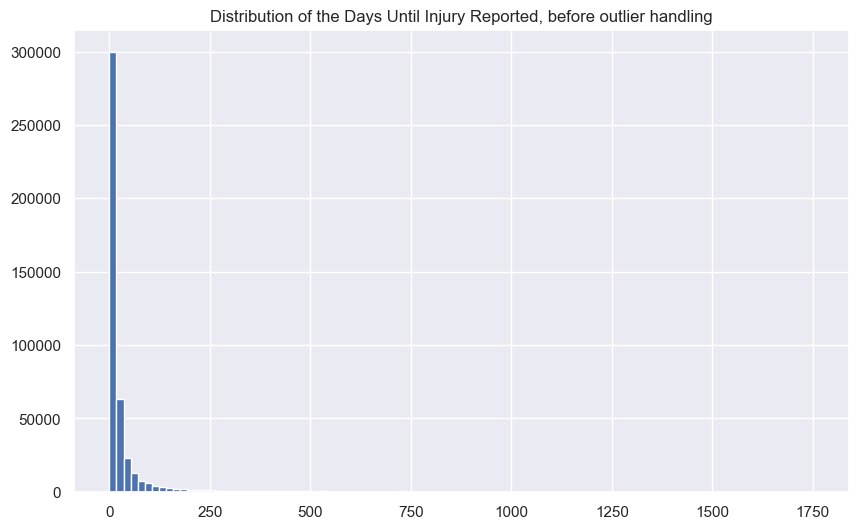

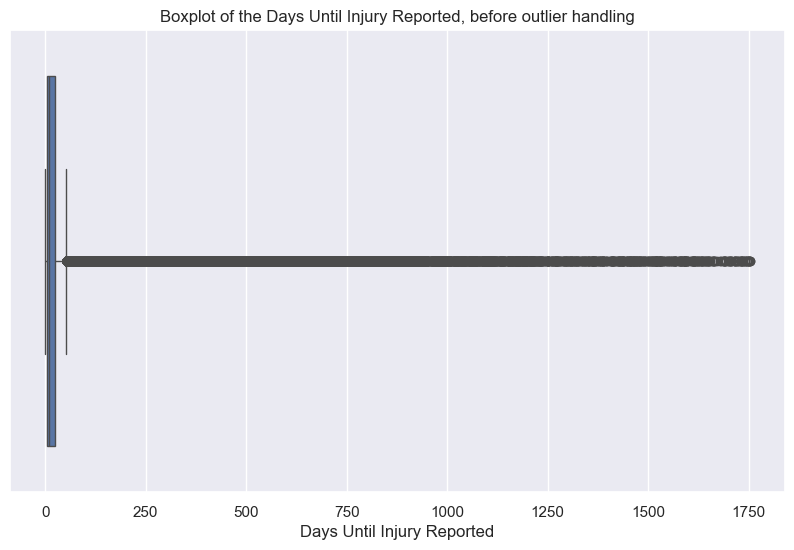

In [93]:
# See the distribution of the Days Until Injury Reported
plt.figure(figsize=(10, 6))
plt.hist(train_data['Days Until Injury Reported'], bins=100)
plt.title('Distribution of the Days Until Injury Reported, before outlier handling')

# Check for outliers in the Days Until Injury Reported column with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['Days Until Injury Reported'])
plt.title('Boxplot of the Days Until Injury Reported, before outlier handling')

Finally we check for the total amount of data that we dropped

In [94]:
# See the amount of data dropped
dropped = (1-(len(train_data)/original_length))*100
print(dropped, " % of the data was dropped.")

7.0081469998483525  % of the data was dropped.


### After handling the missing values, outliers, other weird values as well as feature engineering, we have deleted 7% of the data. This is inside acceptable range (5%-10%)

# Feature Selection

# Bivariate Analysis (metric)

#### Since metadata says this about target variable "Numbering indicates severity", we can also handle Claim Injury Type as numerical value. 1 (cancelled) being the least sever and 8 (death) being the most severe.

#### Mapping this column to numeric value keeps the ordinal severity relationship for model training and now we can also assess the numerical correlations between target and predictors

In [95]:
# See first missing values in Claim Injury Type in training and validation data
print(train_data['Claim Injury Type'].isnull().sum())
print(validation_data['Claim Injury Type'].isnull().sum())

0
0


In [96]:
# Drop rows with missing values in Claim Injury Type
validation_data = validation_data.dropna(subset=['Claim Injury Type'])

In [97]:
# See the unique values in Claim Injury Type column in train, validation and test data
print(train_data['Claim Injury Type'].unique())
print(validation_data['Claim Injury Type'].unique())

# See which values are in validation data but not in train data
print(set(validation_data['Claim Injury Type'].unique()) - set(train_data['Claim Injury Type'].unique()))

# Creating a new column for the target variable as numeric one. NOTE: Later we map the original target varible to this one.

# Take the number from the Claim Injury Type column beginning
train_data['Claim Injury Type Numeric'] = train_data['Claim Injury Type'].str[0]

# Check the unique values in the new column 
print(train_data['Claim Injury Type Numeric'].unique())

# Make the new column integer
train_data['Claim Injury Type Numeric'] = train_data['Claim Injury Type Numeric'].astype(int)

# See the unique values in Claim Injury Type Numeric
print(train_data['Claim Injury Type Numeric'].unique())

# Add the new column to the metric columns
metric_cols.append('Claim Injury Type Numeric')


['2. NON-COMP' '4. TEMPORARY' '5. PPD SCH LOSS' '3. MED ONLY' '6. PPD NSL'
 '1. CANCELLED' '8. DEATH' '7. PTD']
['2. NON-COMP' '4. TEMPORARY' '3. MED ONLY' '1. CANCELLED'
 '5. PPD SCH LOSS' '8. DEATH' '6. PPD NSL' '7. PTD']
set()
['2' '4' '5' '3' '6' '1' '8' '7']
[2 4 5 3 6 1 8 7]


## Pearson's correlation matrix


['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Days Until Injury Reported', 'Claim Injury Type Numeric']


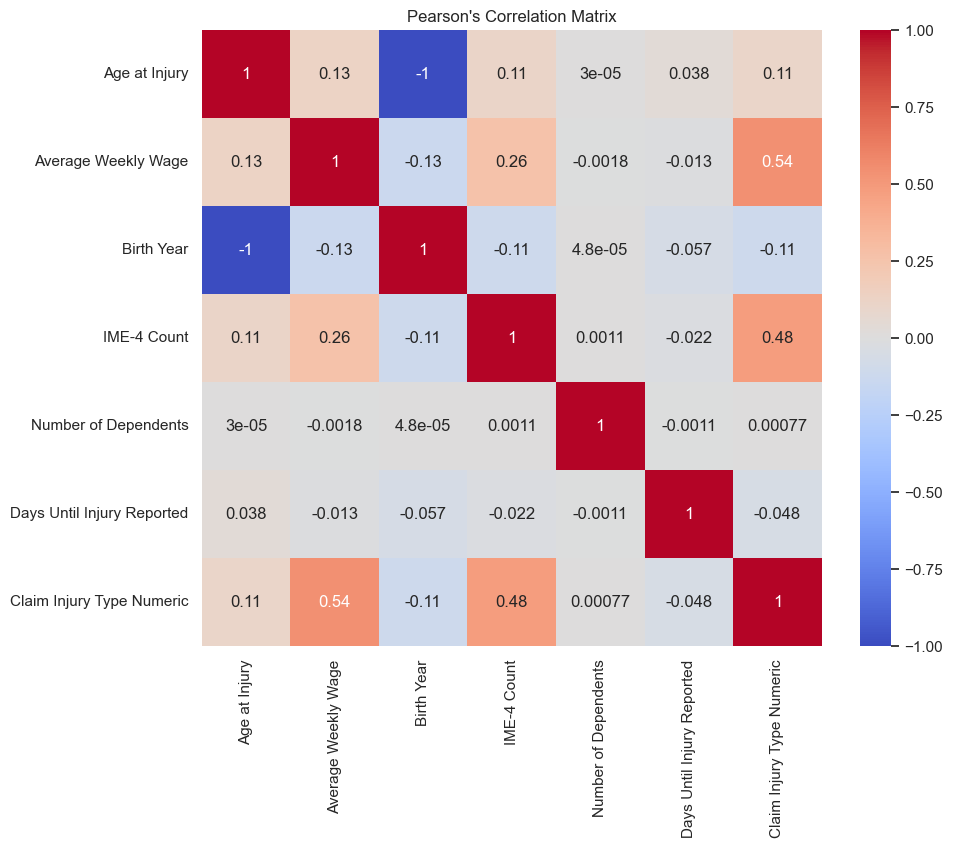

In [98]:
# Plot the Pearson's correlation matrix for the metric columns
print(metric_cols)

# Calculate the correlation matrix
corr = train_data[metric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pearson's Correlation Matrix")
plt.show()

#### After Pearson's correlation we see (it is quite obvious intuitivly) that birth year correlates perfectly with age at injury
- Drop Birth year column

In [99]:
# Drop Birth Year since it has very high correlation with Age at Injury
train_data.drop(columns=['Birth Year'], inplace=True)
metric_cols.remove('Birth Year')

## Pearson's is not enough. We need to check for non-linear relationships as well so we are also plotting Spearman's correlation matrix

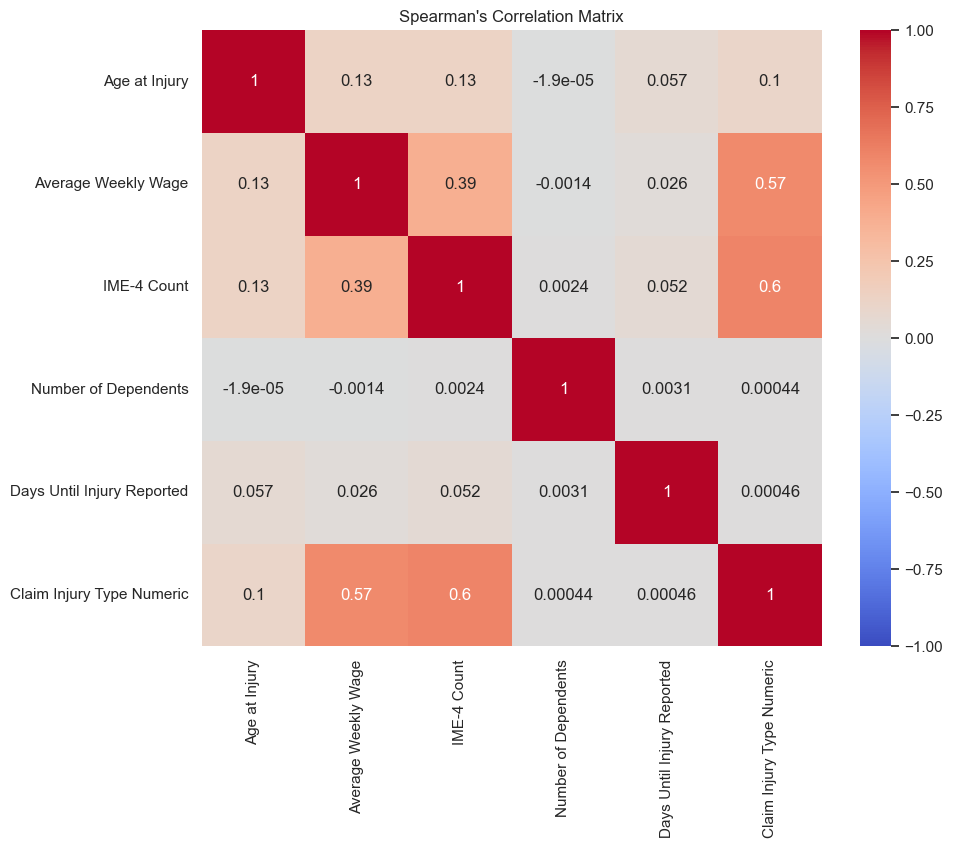

In [100]:
# Calculate the Spearman's correlation matrix for metric columns

# Calculate the correlation matrix
corr = train_data[metric_cols].corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Correlation Matrix")
plt.show()

## Conclusion for bivariate correlation anlysis on metric columns:
* Birth Year column was dropped since it correlated perfectly with Age at Injury (to avoid Redundancy)
* IME-4 count seems to have the most correlation with the target variable out of numerical predictor variables
* Average weekly wage also has almost similar amount of correaltion with the target value as IME-4 Count
* Number of dependents had low correlation with all the other predictor variabels and with target variable

# Non-metric variables analysis

In [101]:
# We saw that Claim Injury Type is not in the non-metric columns. We will move it there.
print(non_metric_cols)
non_metric_cols.append('Claim Injury Type')

['Accident Date', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'Carrier Type', 'District Name', 'Gender', 'Medical Fee Region', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']


#### We excluded datetype columns for phi-k and Cramer's V analysis since the datatype was not accepted by the phik_matrix -function and Carmer's V analysis function

In [102]:
# See the non-meetric columns that we have left
print(non_metric_cols)

# Create list of columns without dates
non_metric_cols_no_dates = [col for col in non_metric_cols if col not in ['Accident Date', 'Assembly Date', 'C-2 Date']]

data_non_metric_no_dates = train_data[non_metric_cols_no_dates]

['Accident Date', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'Carrier Type', 'District Name', 'Gender', 'Medical Fee Region', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Claim Injury Type']


Attorney/Representative       boolean
Carrier Type                   object
District Name                  object
Gender                         object
Medical Fee Region             object
Industry Code                   int64
WCIO Cause of Injury Code       int64
WCIO Nature of Injury Code      int64
WCIO Part Of Body Code          int64
Claim Injury Type              object
dtype: object


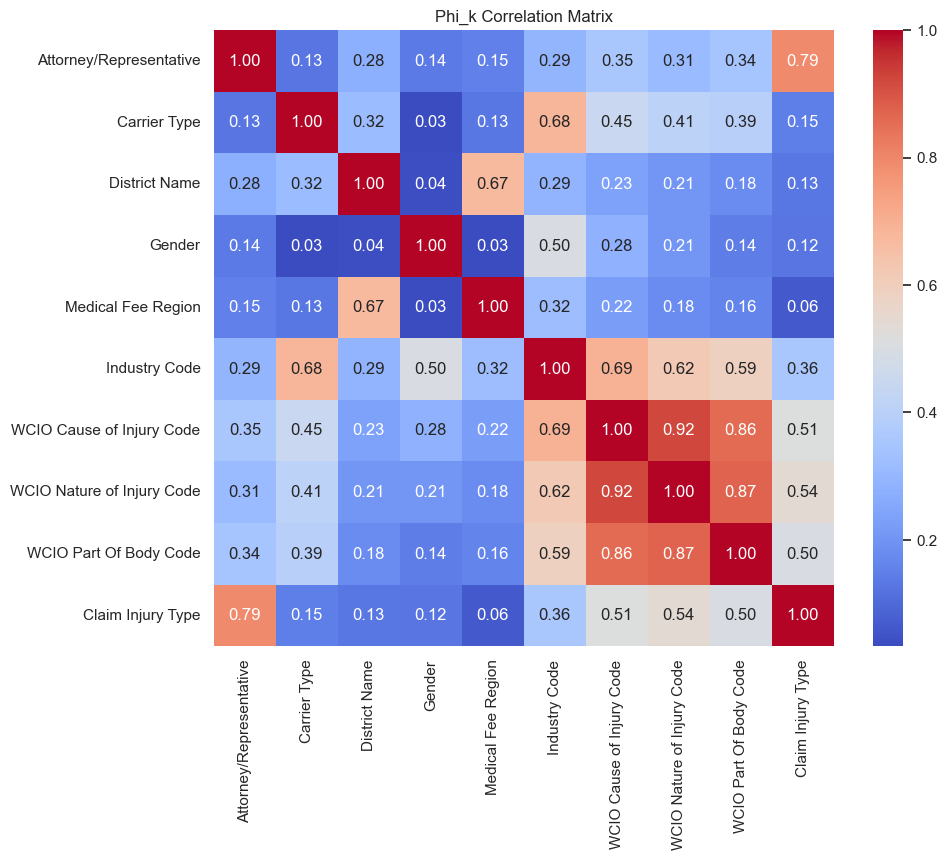

In [103]:
# Plot phi-k correlation matrix for non-metric columns without dates

# See data types of the non-metric columns
print(data_non_metric_no_dates.dtypes)

# Calculate the phi-k correlation matrix
phi_k_corr = data_non_metric_no_dates.phik_matrix(interval_cols=[])

# Plot the phi_k correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(phi_k_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Phi_k Correlation Matrix')
plt.show()

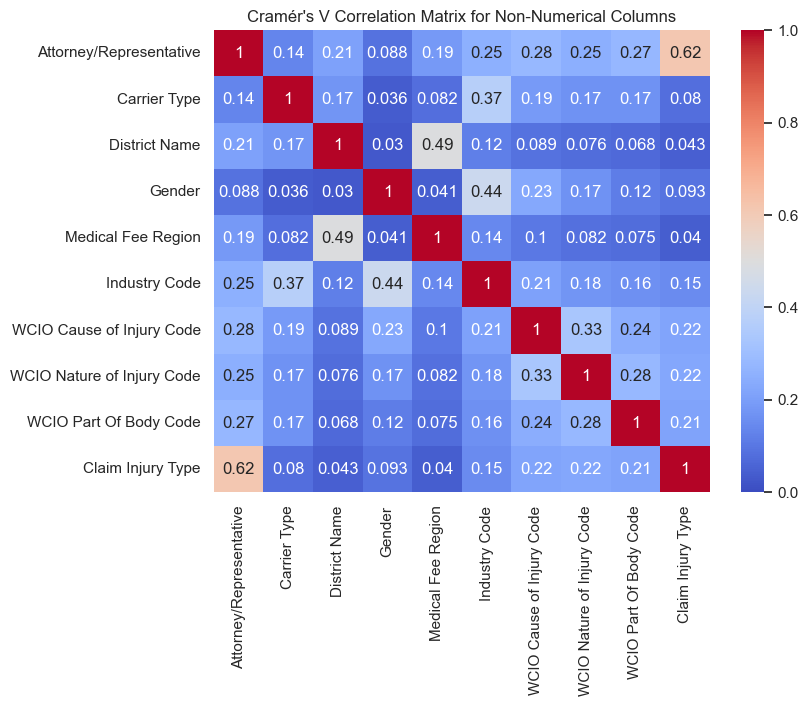

In [104]:
# Plot Cramer's V correlation matrix for non-metric columns without dates

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Function to calculate the correlation matrix using Cramér's V
def calculate_cramers_v_matrix(df):
    cols = df.columns
    n = len(cols)
    cramers_v_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)

    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i <= j:  # Only calculate the upper triangle (symmetric matrix)
                cramers_v_value = cramers_v(df[col1], df[col2])
                cramers_v_matrix.iloc[i, j] = cramers_v_value
                cramers_v_matrix.iloc[j, i] = cramers_v_value
    
    return cramers_v_matrix


# Calculate the Cramér's V correlation matrix for the data
cramers_v_matrix = calculate_cramers_v_matrix(data_non_metric_no_dates)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Matrix for Non-Numerical Columns")
plt.show()

### Conclusion on non-metric bivariate correlation analysis:
* Attorney/Representative correlates the most out of the non-numerical variables with target variable --> We will definitely keep this
* Medical Fee Region correlates very poorly with target variable (and it is also somewhat represented in District Code) so we decided to drop the column

In [105]:
# Drop the medical fee region column since it shows irrelevancy with the target variable

train_data.drop(columns=['Medical Fee Region'], inplace=True)
data_non_metric_no_dates.drop(columns=['Medical Fee Region'], inplace=True)

non_metric_cols.remove('Medical Fee Region')
non_metric_cols_no_dates.remove('Medical Fee Region')

/var/folders/hr/bvcr3w9n2gxgqdhjgthjjnv80000gn/T/ipykernel_1777/3544734139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_non_metric_no_dates.drop(columns=['Medical Fee Region'], inplace=True)


In [106]:
# Check column names
print(list(train_data.columns))
print(non_metric_cols)

['Accident Date', 'Age at Injury', 'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date', 'Carrier Type', 'Claim Injury Type', 'District Name', 'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents', 'Days Until Injury Reported', 'Claim Injury Type Numeric']
['Accident Date', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'Carrier Type', 'District Name', 'Gender', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Claim Injury Type']


# Summary of all correlations


* High correlations between target variable
    * Attorney/Representative correlates the most with target variable out of all non-numeric predictor variables
    * IME-4 count seems to have the most correlation with the target variable out of numerical predictor variables
* Redundancies
    * Birth Year column was dropped since it correlated perfectly with Age at Injury (to avoid Redundancy)
    * WCIO Cause of Injury Code, WCIO Nature of Injury Code and WCIO Part Of Body Code had high correlations between each other AND nice correlations between target variable.
        * We can consider droppig one or two of these to avoid redundancy
* Irrelevancies
    * Number of dependents had low correlation with all the other predictor variabels and with target variable
    * Medical Fee Region correlates very poorly with target variable (and it is also somewhat represented in District Code) so we decided to drop the column

#### We can now change the original target column to be the numerical representation of it. This will be beneficial in model fitting phase.

In [107]:
# Store original mapping in Claim Injury Type
# Create mapping of the all the unique values in the Claim Injury Type column in the train data
unique_claim_injury_type_train = train_data['Claim Injury Type'].unique()

# Get the number of unique values from the beginnig of the Claim Injury Type
unique_claim_injury_type_train_values = [x[0] for x in unique_claim_injury_type_train]

# Map unique_claim_injury_type_train_values to be type int
unique_claim_injury_type_train_values = list(map(int, unique_claim_injury_type_train_values))

print(unique_claim_injury_type_train)
print(unique_claim_injury_type_train_values)

#Create a dictionary for the mapping
claim_injury_type_mapping = dict(zip(unique_claim_injury_type_train_values, unique_claim_injury_type_train))

print(claim_injury_type_mapping)

['2. NON-COMP' '4. TEMPORARY' '5. PPD SCH LOSS' '3. MED ONLY' '6. PPD NSL'
 '1. CANCELLED' '8. DEATH' '7. PTD']
[2, 4, 5, 3, 6, 1, 8, 7]
{2: '2. NON-COMP', 4: '4. TEMPORARY', 5: '5. PPD SCH LOSS', 3: '3. MED ONLY', 6: '6. PPD NSL', 1: '1. CANCELLED', 8: '8. DEATH', 7: '7. PTD'}


In [108]:
# Drop the Claim Injury Type Numeric column from metric_cols since we have the original Claim Injury Type column
metric_cols.remove('Claim Injury Type Numeric')

# Drop the Claim Injury Type Numeric column from the train data
train_data.drop(columns=['Claim Injury Type Numeric'], inplace=True)

# Map the Claim Injury Type column according to mapping
train_data['Claim Injury Type'] = train_data['Claim Injury Type'].str[0].astype(int)
validation_data['Claim Injury Type'] = validation_data['Claim Injury Type'].str[0].astype(int)

# See the unique values in Claim Injury Type
print(train_data['Claim Injury Type'].unique())

[2 4 5 3 6 1 8 7]


In [109]:
# See all test data columns
print(train_data.columns)

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'Claim Injury Type', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


#### Now we will drop all the columns from test data and validation data, which were also dropped from training data

In [110]:
# See all columns the test_data has that the train_data doesn't have
print(set(test_data.columns) - set(train_data.columns))

# Drop the columns that the test_data has that the train_data doesn't have. 
for col in set(test_data.columns) - set(train_data.columns):
    test_data.drop(columns=[col], inplace=True)

# Check the columns that the train_data has that the test_data doesn't have
print(set(train_data.columns) - set(test_data.columns))

{'Zip Code', 'WCIO Nature of Injury Description', 'County of Injury', 'Medical Fee Region', 'Carrier Name', 'OIICS Nature of Injury Description', 'COVID-19 Indicator', 'Industry Code Description', 'WCIO Cause of Injury Description', 'Alternative Dispute Resolution', 'Birth Year', 'WCIO Part Of Body Description', 'C-3 Date', 'First Hearing Date'}
{'Days Until Injury Reported', 'Claim Injury Type'}


In [111]:
# See all columns the validation data has that the train_data doesn't have
print(set(validation_data.columns) - set(train_data.columns))

# Drop the columns that the test_data has that the train_data doesn't have. 
for col in set(validation_data.columns) - set(train_data.columns):
    validation_data.drop(columns=[col], inplace=True)

# Check the columns that the train_data has that the test_data doesn't have
print(set(train_data.columns) - set(validation_data.columns))

{'Zip Code', 'WCIO Nature of Injury Description', 'County of Injury', 'Medical Fee Region', 'Carrier Name', 'OIICS Nature of Injury Description', 'COVID-19 Indicator', 'Industry Code Description', 'WCIO Cause of Injury Description', 'Agreement Reached', 'Alternative Dispute Resolution', 'WCB Decision', 'Birth Year', 'WCIO Part Of Body Description', 'C-3 Date', 'First Hearing Date'}
{'Days Until Injury Reported'}


### For columns left in test_data & validation_data, we need to perform same operations as we did for train_data

In [112]:
# Check for missing values in the validation data
print(((validation_data.isnull().sum() / len(validation_data)) * 100).sort_values(ascending=False))

# And absolute number of missing values sorted
print(validation_data.isnull().sum().sort_values(ascending=False))

# Check length of the validation data
print(len(validation_data))

IME-4 Count                   77.016010
Average Weekly Wage            4.968381
WCIO Part Of Body Code         3.086947
WCIO Cause of Injury Code      2.839573
WCIO Nature of Injury Code     2.838702
C-2 Date                       2.639235
Industry Code                  1.810010
Accident Date                  0.641081
Age at Injury                  0.000000
Assembly Date                  0.000000
Attorney/Representative        0.000000
Carrier Type                   0.000000
Claim Injury Type              0.000000
District Name                  0.000000
Gender                         0.000000
Number of Dependents           0.000000
dtype: float64
IME-4 Count                   88419
Average Weekly Wage            5704
WCIO Part Of Body Code         3544
WCIO Cause of Injury Code      3260
WCIO Nature of Injury Code     3259
C-2 Date                       3030
Industry Code                  2078
Accident Date                   736
Age at Injury                     0
Assembly Date        

### Number 3.285732% is very repetitive accross columns for missing values in validation data.
*  We will do the same as for training data: Test if they are same rows, and then delete them if they are

In [113]:
# Let's check id these are all same rows. If they are, they can be deleted since they have so much missing values.

# Check if the rows with missing values in the specified columns are the same
missing_rows = validation_data[
    validation_data[['Age at Injury', 'Gender', 'Number of Dependents', 
                'District Name', 'Carrier Type', 'Attorney/Representative', ]].isnull().all(axis=1)
]

# Display the unique index values of the rows with missing values
unique_missing_indices = missing_rows.index.unique()

# If this is 3900, we can delete these rows since they are all the same.
print(len(unique_missing_indices))

# Drop the rows with missing values in the specified columns
validation_data.drop(index=unique_missing_indices, inplace=True)

# Check for missing values in the validation data
print(((validation_data.isnull().sum() / len(validation_data)) * 100).sort_values(ascending=False))


0
IME-4 Count                   77.016010
Average Weekly Wage            4.968381
WCIO Part Of Body Code         3.086947
WCIO Cause of Injury Code      2.839573
WCIO Nature of Injury Code     2.838702
C-2 Date                       2.639235
Industry Code                  1.810010
Accident Date                  0.641081
Age at Injury                  0.000000
Assembly Date                  0.000000
Attorney/Representative        0.000000
Carrier Type                   0.000000
Claim Injury Type              0.000000
District Name                  0.000000
Gender                         0.000000
Number of Dependents           0.000000
dtype: float64


#### IME-4 Count: Mising values

In [114]:
# Handle missing values in IME-4 Count the same way as in train data
validation_data['IME-4 Count'] = validation_data['IME-4 Count'].fillna(0)

# Check for missing values in the test data
print(((validation_data.isnull().sum() / len(validation_data)) * 100).sort_values(ascending=False))

Average Weekly Wage           4.968381
WCIO Part Of Body Code        3.086947
WCIO Cause of Injury Code     2.839573
WCIO Nature of Injury Code    2.838702
C-2 Date                      2.639235
Industry Code                 1.810010
Accident Date                 0.641081
Age at Injury                 0.000000
Assembly Date                 0.000000
Attorney/Representative       0.000000
Carrier Type                  0.000000
Claim Injury Type             0.000000
District Name                 0.000000
Gender                        0.000000
IME-4 Count                   0.000000
Number of Dependents          0.000000
dtype: float64


#### Accident Date: Missing values
* We will delete rows with missing values in accident date.

In [115]:
# Delete the rows with missing values in the accident date column
validation_data.dropna(subset=['Accident Date'], inplace=True)

# Check for missing values in the validation data
print(((validation_data.isnull().sum() / len(validation_data)) * 100).sort_values(ascending=False))

Average Weekly Wage           4.963619
WCIO Part Of Body Code        2.844744
WCIO Cause of Injury Code     2.587885
WCIO Nature of Injury Code    2.585255
C-2 Date                      2.395021
Industry Code                 1.665644
Accident Date                 0.000000
Age at Injury                 0.000000
Assembly Date                 0.000000
Attorney/Representative       0.000000
Carrier Type                  0.000000
Claim Injury Type             0.000000
District Name                 0.000000
Gender                        0.000000
IME-4 Count                   0.000000
Number of Dependents          0.000000
dtype: float64


## Date columns datatype conversions for validation data
* This is needed to do here since next we need to perform some imputations and calculations to datetype objects

In [116]:
# Like in training data, convert dates to datetime format
validation_data['Accident Date'] = pd.to_datetime(validation_data['Accident Date'])
validation_data['Assembly Date'] = pd.to_datetime(validation_data['Assembly Date'])
validation_data['C-2 Date'] = pd.to_datetime(validation_data['C-2 Date'])


#### C-2 Date: Missing values

In [117]:
# Fill missing values in C-2 Date with Accident Date + 10 days (10 days was the median difference between Accident Date and C-2 Date in training data)
validation_data['C-2 Date'].fillna(validation_data['Accident Date'] + pd.Timedelta(days=10), inplace=True)

# Check for missing values in the validation data
print(((validation_data.isnull().sum() / len(validation_data)) * 100).sort_values(ascending=False))

Average Weekly Wage           4.963619
WCIO Part Of Body Code        2.844744
WCIO Cause of Injury Code     2.587885
WCIO Nature of Injury Code    2.585255
Industry Code                 1.665644
Accident Date                 0.000000
Age at Injury                 0.000000
Assembly Date                 0.000000
Attorney/Representative       0.000000
C-2 Date                      0.000000
Carrier Type                  0.000000
Claim Injury Type             0.000000
District Name                 0.000000
Gender                        0.000000
IME-4 Count                   0.000000
Number of Dependents          0.000000
dtype: float64


/var/folders/hr/bvcr3w9n2gxgqdhjgthjjnv80000gn/T/ipykernel_1777/255666720.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  validation_data['C-2 Date'].fillna(validation_data['Accident Date'] + pd.Timedelta(days=10), inplace=True)


#### Industry code and WCIO... columns: Missing values
* We do the same we did for training data
* "Set missing as unknown for the WCIO-related codes and industry columns (0 for codes and "UNKNOWN" for descriptions):
Mapping empty as an "Unknown" category preserves all data while acknowledging the missing values."

In [118]:
# Set missing as unknown for Industry Code (0)
validation_data['Industry Code'] = validation_data['Industry Code'].fillna(0)

# WCIO Part Of Body Code and WCIO Part Of Body Code  
# Set missing as unknown (0)
validation_data['WCIO Part Of Body Code'] = validation_data['WCIO Part Of Body Code'].fillna(0)

# WCIO Nature of Injury Code
# Set missing as unknown (0)
validation_data['WCIO Nature of Injury Code'] = validation_data['WCIO Nature of Injury Code'].fillna(0)

# WCIO Cause of Injury Code and WCIO Cause of Injury Code    
# Set missing as unknown (0)
validation_data['WCIO Cause of Injury Code'] = validation_data['WCIO Cause of Injury Code'].fillna(0)

#### Average Weekly Wage: Missing values
* Impute with Industry code based median calculated from training data
* We also assumed that zeroes are missing values in data, so those will be mapped to the industry code median as well

In [119]:
# First fill missing values in Average Weekly Wage with zeros
validation_data['Average Weekly Wage'] = validation_data['Average Weekly Wage'].fillna(0)

# Check amout of zero values in Average Weekly Wage
print(len(validation_data[validation_data['Average Weekly Wage'] == 0]))

# Fill the zero values in the Average Weekly Wage column with the median of the industry
validation_data['Average Weekly Wage'] = validation_data.apply(lambda row: mean_wage_mapping[row['Industry Code']] if row['Average Weekly Wage'] == 0 else row['Average Weekly Wage'], axis=1)

# Check the amount of zero values in Average Weekly Wage
print(len(validation_data[validation_data['Average Weekly Wage'] == 0]))

72119
0


In [120]:
# Check min, max and mean and median values of the Average Weekly Wage column
print(validation_data['Average Weekly Wage'].min())
print(validation_data['Average Weekly Wage'].max())
print(validation_data['Average Weekly Wage'].mean())
print(validation_data['Average Weekly Wage'].median())

23.27
360000.0
751.9754075567635
503.88


In [121]:
# Check missing values in the validation data
print(((validation_data.isnull().sum() / len(validation_data)) * 100).sort_values(ascending=False))

Accident Date                 0.0
Age at Injury                 0.0
Assembly Date                 0.0
Attorney/Representative       0.0
Average Weekly Wage           0.0
C-2 Date                      0.0
Carrier Type                  0.0
Claim Injury Type             0.0
District Name                 0.0
Gender                        0.0
IME-4 Count                   0.0
Industry Code                 0.0
WCIO Cause of Injury Code     0.0
WCIO Nature of Injury Code    0.0
WCIO Part Of Body Code        0.0
Number of Dependents          0.0
dtype: float64


In [122]:
# Check length of the validation data
print(len(validation_data))

# Check how many percentage the length of validation data is from the original length of the training data
print((len(validation_data) / len(train_data_nosplit)) * 100)

114070
19.871922177741077


In [123]:
# For columns left in test_data & validation_data, we need to perform same operations as we did for train_data
print(test_data.columns)
print(validation_data.columns)

# Column by column operations for test_data

# Accident Date
# Convert the Accident Date to datetime
test_data['Accident Date'] = pd.to_datetime(test_data['Accident Date'])
#DONE ALREADY FOR VALIDATION DATA

# Age at Injury
# Map to integer
test_data['Age at Injury'] = test_data['Age at Injury'].astype(int)
validation_data['Age at Injury'] = validation_data['Age at Injury'].astype(int)

# Assembly Date
# Convert the Assembly Date to datetime
test_data['Assembly Date'] = pd.to_datetime(test_data['Assembly Date'])
#DONE ALREADY FOR VALIDATION DATA

# Attorney/Representative
# Map the Attorney/Representative to boolean
test_data['Attorney/Representative'] = test_data['Attorney/Representative'].map({'Y': True, 'N': False}).astype('boolean')
validation_data['Attorney/Representative'] = validation_data['Attorney/Representative'].map({'Y': True, 'N': False}).astype('boolean')

# C-2 Date
# Convert the C-2 Date to datetime
test_data['C-2 Date'] = pd.to_datetime(test_data['C-2 Date'])
#DONE ALREADY FOR VALIDATION DATA

# Carrier Type
# Nothing

# District Name
# Nothing

# Gender
# Nothing

# IME-4 Count
# Nothing


Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents'],
      dtype='object')
Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'Claim Injury Type', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents'],
      dtype='object')


In [124]:
# Industry Code
# Map to integer
test_data['Industry Code'] = test_data['Industry Code'].fillna(0)
test_data['Industry Code'] = test_data['Industry Code'].astype(int)
validation_data['Industry Code'] = validation_data['Industry Code'].astype(int)

# WCIO Cause of Injury Code
# Map to integer
test_data['WCIO Cause of Injury Code'] = test_data['WCIO Cause of Injury Code'].fillna(0)
test_data['WCIO Cause of Injury Code'] = test_data['WCIO Cause of Injury Code'].astype(int)
validation_data['WCIO Cause of Injury Code'] = validation_data['WCIO Cause of Injury Code'].astype(int)

# WCIO Nature of Injury Code
# Map to integer
test_data['WCIO Nature of Injury Code'] = test_data['WCIO Nature of Injury Code'].fillna(0)
test_data['WCIO Nature of Injury Code'] = test_data['WCIO Nature of Injury Code'].astype(int)
validation_data['WCIO Nature of Injury Code'] = validation_data['WCIO Nature of Injury Code'].astype(int)

# WCIO Part Of Body Code
# Map to integer
test_data['WCIO Part Of Body Code'] = test_data['WCIO Part Of Body Code'].fillna(0)
test_data['WCIO Part Of Body Code'] = test_data['WCIO Part Of Body Code'].astype(int)
validation_data['WCIO Part Of Body Code'] = validation_data['WCIO Part Of Body Code'].astype(int)


In [125]:

# Number of Dependents
# Map to float
test_data['Number of Dependents'] = test_data['Number of Dependents'].astype(float)
validation_data['Number of Dependents'] = validation_data['Number of Dependents'].astype(float)

### Ensure that the test data columns have same type as train data columns

In [126]:
# Ensure that the test data columns have same type as train data columns

# Get columns in train_data as list
train_data_cols = list(train_data.columns)
print(train_data_cols)

# Check the data types of the columns in train_data
print(train_data.dtypes)

# Check the data types of the columns in test_data
print(test_data.dtypes)

# Check the data types of the columns in validation_data
print(validation_data.dtypes)

['Accident Date', 'Age at Injury', 'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date', 'Carrier Type', 'Claim Injury Type', 'District Name', 'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents', 'Days Until Injury Reported']
Accident Date                 datetime64[ns]
Age at Injury                          int64
Assembly Date                 datetime64[ns]
Attorney/Representative              boolean
Average Weekly Wage                  float64
C-2 Date                      datetime64[ns]
Carrier Type                          object
Claim Injury Type                      int64
District Name                         object
Gender                                object
IME-4 Count                          float64
Industry Code                          int64
WCIO Cause of Injury Code              int64
WCIO Nature of Injury Code             int64
WCIO Part Of Body Cod

#### We see that the test data is missing Claim Injury Type column. This is OK since this is the column we are trying to predict.

In [127]:
# See which columns are in train_data but not in test_data and validation_data

# Check which columns are in train_data but not in test_data
print(set(train_data_cols) - set(test_data.columns))

# Check which columns are in train_data but not in validation_data
print(set(train_data_cols) - set(validation_data.columns))

{'Days Until Injury Reported', 'Claim Injury Type'}
{'Days Until Injury Reported'}


## Handling of missing values in test data's Accident Date column
* We deleted the rows in the training data where Accident Date was missing
* We are not allowed to delete testing data (due to Kaggle), so same operation is not possible for testing data case
    * We decided to calculate median of the Days Until Injury Reported -variable (difference between accident date and assembly date) and impute missing values in testing data's accident date -column by substracting the median(training data median) of Days Until Injury Reported from the assembly date.
    * The resulting date approximates the accident date in testing data

In [128]:
# See missing values in test_data
print(((test_data.isnull().sum() / len(test_data)) * 100).sort_values(ascending=False))

IME-4 Count                   90.914621
Average Weekly Wage            4.949803
C-2 Date                       2.354275
Accident Date                  0.629937
Age at Injury                  0.000000
Assembly Date                  0.000000
Attorney/Representative        0.000000
Carrier Type                   0.000000
District Name                  0.000000
Gender                         0.000000
Industry Code                  0.000000
WCIO Cause of Injury Code      0.000000
WCIO Nature of Injury Code     0.000000
WCIO Part Of Body Code         0.000000
Number of Dependents           0.000000
dtype: float64


In [129]:
# Fill missing values first in the test data in Accident Date

# Calculate the median of difference between Accident Date and Assembly Date in the train data
median_days_until_injury_reported = train_data['Days Until Injury Reported'].median()

# Fill missing values in Accident Date with assembly date minus median of days_until_injury_reported
test_data['Accident Date'].fillna(test_data['Assembly Date'] - pd.Timedelta(days=median_days_until_injury_reported), inplace=True)


/var/folders/hr/bvcr3w9n2gxgqdhjgthjjnv80000gn/T/ipykernel_1777/3928073060.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Accident Date'].fillna(test_data['Assembly Date'] - pd.Timedelta(days=median_days_until_injury_reported), inplace=True)


### We also see that the test_data is missing Days Until Injury Reported that we created to the training data. We need to create this column for the test data as well, in the similar manner we did for the training data.

In [130]:
# We also see that the test_data is missing Days Until Injury Reported. We need to create this column for the test data as well.
test_data['Days Until Injury Reported'] = (test_data['Assembly Date'] - test_data['Accident Date']).dt.days

# See that now the only column missing from the test data is the Claim Injury Type column
print(set(train_data.columns) - set(test_data.columns))

{'Claim Injury Type'}


In [131]:
# Create the Claim Injury Type column for the validation data as well
validation_data['Days Until Injury Reported'] = (validation_data['Assembly Date'] - validation_data['Accident Date']).dt.days

print(set(train_data.columns) - set(validation_data.columns))

set()


# Handle datatype conversion so that datatypes are acceptable for the model fitting
* Datetimes need to change to something else
* boolean to int (0 and 1)
* One-Hot Encoding or ordinal encoding for objects

#### For Carrier type, Gender and District Name, we did label encoding. Encoding translates string type labels to numeric ones.

In [132]:
# Get all columns with datatype object
object_cols = train_data.select_dtypes(include=['object']).columns.tolist()
print(object_cols)

# We need to create mapping for unique values in the object columns
# Find all unique values in Carrier Type and give them a unique number (starting from 1)

# Carrier Type
# Find all unique values in Carrier Type
unique_carrier_type = train_data['Carrier Type'].unique()
print(unique_carrier_type)

# Create a mapping for Carrier Type
carrier_type_mapping = {carrier_type: i+1 for i, carrier_type in enumerate(unique_carrier_type)}
print(carrier_type_mapping)

# For training and test data, map the Carrier Type column to the unique number and change the datatype to integer
train_data['Carrier Type'] = train_data['Carrier Type'].map(carrier_type_mapping)
print(train_data['Carrier Type'].unique())

['Carrier Type', 'District Name', 'Gender']
['3A. SELF PUBLIC' '1A. PRIVATE' '2A. SIF' '4A. SELF PRIVATE'
 '5D. SPECIAL FUND - UNKNOWN' 'UNKNOWN'
 '5C. SPECIAL FUND - POI CARRIER WCB MENANDS']
{'3A. SELF PUBLIC': 1, '1A. PRIVATE': 2, '2A. SIF': 3, '4A. SELF PRIVATE': 4, '5D. SPECIAL FUND - UNKNOWN': 5, 'UNKNOWN': 6, '5C. SPECIAL FUND - POI CARRIER WCB MENANDS': 7}
[1 2 3 4 5 6 7]


In [133]:
# Check the unqiue values in Carrier Type in test data and validation data
unique_carrier_type_test = test_data['Carrier Type'].unique()
unique_carrier_type_validation = validation_data['Carrier Type'].unique()

# Find the values in test data that are not in train data
print(set(unique_carrier_type_test) - set(unique_carrier_type))
print(set(unique_carrier_type_validation) - set(unique_carrier_type))


{'5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)'}
{'5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)'}


In [134]:

# For the unique values in test data that are not in train data, we will map them to one bigger than the biggest number in train data
for carrier_type in set(unique_carrier_type_test) - set(unique_carrier_type):
    carrier_type_mapping[carrier_type] = max(carrier_type_mapping.values()) + 1

print(carrier_type_mapping)

# Map the Carrier Type column in test data and validation data
test_data['Carrier Type'] = test_data['Carrier Type'].map(carrier_type_mapping)
validation_data['Carrier Type'] = validation_data['Carrier Type'].map(carrier_type_mapping)

{'3A. SELF PUBLIC': 1, '1A. PRIVATE': 2, '2A. SIF': 3, '4A. SELF PRIVATE': 4, '5D. SPECIAL FUND - UNKNOWN': 5, 'UNKNOWN': 6, '5C. SPECIAL FUND - POI CARRIER WCB MENANDS': 7, '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)': 8}


In [135]:
#Gender mapping

# Get all unique values for gender in train data
unique_genders_train = train_data['Gender'].unique()
print(unique_genders_train)

# Get all unique values for gender in test data
unique_genders_test = test_data['Gender'].unique()
print(unique_genders_test)

# Get all unique values for gender in validation data
unique_genders_validation = validation_data['Gender'].unique()
print(unique_genders_validation)

['M' 'F']
['M' 'F' 'U' 'X']
['F' 'M' 'U' 'X']


In [136]:

# Create the mapping accoring to the unique values in test data
gender_mapping = {gender: i+1 for i, gender in enumerate(unique_genders_test)}
print(gender_mapping)

# Do the mapping for both train and test data and change the datatype to integer
train_data['Gender'] = train_data['Gender'].map(gender_mapping)
test_data['Gender'] = test_data['Gender'].map(gender_mapping)
validation_data['Gender'] = validation_data['Gender'].map(gender_mapping)

print(train_data['Gender'].unique())
print(test_data['Gender'].unique())
print(validation_data['Gender'].unique())

{'M': 1, 'F': 2, 'U': 3, 'X': 4}
[1 2]
[1 2 3 4]
[2 1 3 4]


In [137]:
# District Name
# Find all unique values in District Name
unique_district_name_train  = train_data['District Name'].unique()
unique_district_name_test = test_data['District Name'].unique()
unique_district_name_validation = validation_data['District Name'].unique()

print(unique_district_name_train)
print(unique_district_name_test)
print(unique_district_name_validation)

# Find all unique values in District Name from train, test and validation data
unique_district_name = np.unique(np.concatenate((unique_district_name_train, unique_district_name_test, unique_district_name_validation)))
print(unique_district_name)


['ALBANY' 'NYC' 'BINGHAMTON' 'HAUPPAUGE' 'ROCHESTER' 'BUFFALO' 'SYRACUSE'
 'STATEWIDE']
['NYC' 'ALBANY' 'BUFFALO' 'SYRACUSE' 'BINGHAMTON' 'HAUPPAUGE' 'ROCHESTER'
 'STATEWIDE']
['HAUPPAUGE' 'SYRACUSE' 'NYC' 'BUFFALO' 'ALBANY' 'ROCHESTER' 'BINGHAMTON'
 'STATEWIDE']
['ALBANY' 'BINGHAMTON' 'BUFFALO' 'HAUPPAUGE' 'NYC' 'ROCHESTER' 'STATEWIDE'
 'SYRACUSE']


In [138]:
# Create a mapping for District Name
district_name_mapping = {district_name: i+1 for i, district_name in enumerate(unique_district_name)}
print(district_name_mapping)

# For training,test and validation data, map the District Name column to the unique number and change the datatype to integer
train_data['District Name'] = train_data['District Name'].map(district_name_mapping)
test_data['District Name'] = test_data['District Name'].map(district_name_mapping)
validation_data['District Name'] = validation_data['District Name'].map(district_name_mapping)


print(train_data['District Name'].unique())
print(test_data['District Name'].unique())
print(validation_data['District Name'].unique())

{'ALBANY': 1, 'BINGHAMTON': 2, 'BUFFALO': 3, 'HAUPPAUGE': 4, 'NYC': 5, 'ROCHESTER': 6, 'STATEWIDE': 7, 'SYRACUSE': 8}
[1 5 2 4 6 3 8 7]
[5 1 3 8 2 4 6 7]
[4 8 5 3 1 6 2 7]


#### For boolean type columns, Falses and Trues were mapped to 0s and 1s.

In [139]:
# Get all boolean columns
boolean_cols = train_data.select_dtypes(include=['boolean']).columns.tolist()
print(boolean_cols)

print(train_data['Attorney/Representative'].unique())
print(test_data['Attorney/Representative'].unique())
print(validation_data['Attorney/Representative'].unique())


['Attorney/Representative']
<BooleanArray>
[False, True]
Length: 2, dtype: boolean
<BooleanArray>
[False, True]
Length: 2, dtype: boolean
<BooleanArray>
[False, True]
Length: 2, dtype: boolean


In [140]:
# Turn the boolean 'Attorney/Representative' to integer
train_data['Attorney/Representative'] = train_data['Attorney/Representative'].astype(int)
test_data['Attorney/Representative'] = test_data['Attorney/Representative'].astype(int)
validation_data['Attorney/Representative'] = validation_data['Attorney/Representative'].astype(int)

print(train_data['Attorney/Representative'].unique())
print(test_data['Attorney/Representative'].unique())
print(validation_data['Attorney/Representative'].unique())

[0 1]
[0 1]
[0 1]


## Handle missing values in Test datas date columns (Accident Date already handled)

#### For C-2 Date missing values were handled similarly to training data.

In [141]:
# Check for missing values in the datetime objects in the test data
print(test_data[['Accident Date', 'Assembly Date', 'C-2 Date']].isnull().sum())

# Accident Dates Handled already
# Fill missing values in C-2 Date with Accident Date + 10 days (10 days was the median difference between Accident Date and C-2 Date in training data)
test_data['C-2 Date'].fillna(test_data['Accident Date'] + pd.Timedelta(days=10), inplace=True)

# Check for missing values in the datetime objects in the test data
print(test_data[['Accident Date', 'Assembly Date', 'C-2 Date']].isnull().sum())

Accident Date       0
Assembly Date       0
C-2 Date         9134
dtype: int64
Accident Date    0
Assembly Date    0
C-2 Date         0
dtype: int64


/var/folders/hr/bvcr3w9n2gxgqdhjgthjjnv80000gn/T/ipykernel_1777/249994355.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['C-2 Date'].fillna(test_data['Accident Date'] + pd.Timedelta(days=10), inplace=True)


## Conversion of date type variables to numeric variables in training,validation and testing data

* This conversion was mandatory so that we can use datetype columns for model training
* For all the datetime-type columns left, we calculated the difference between today and the date in the column and imouted the difference to the column

In [142]:
# Get all datetime columns
datetime_cols = train_data.select_dtypes(include=['datetime']).columns.tolist()
print(datetime_cols)

# Create this day as pd.datetime
today = pd.to_datetime('today')

# Update the original columns with the number of days from today
for col in ['Accident Date', 'Assembly Date', 'C-2 Date']:
    train_data[col] = (today - train_data[col]).dt.days
# Display the updated DataFrame and statistics
print(train_data[['Accident Date', 'Assembly Date', 'C-2 Date']])
print(train_data[['Accident Date', 'Assembly Date', 'C-2 Date']].describe())


['Accident Date', 'Assembly Date', 'C-2 Date']
                  Accident Date  Assembly Date  C-2 Date
Claim Identifier                                        
6057673                     848            846       846
5918256                    1054           1028      1028
6054143                     859            852       852
6009943                     923            909       909
5627232                    1435           1434      1434
...                         ...            ...       ...
5437498                    1747           1743      1743
5729465                    1292           1289      1289
5742588                    1276           1271      1271
5624451                    1492           1441      1442
5796296                    1249           1197      1197

[441503 rows x 3 columns]
       Accident Date  Assembly Date       C-2 Date
count  441503.000000  441503.000000  441503.000000
mean     1265.186862    1231.002061    1226.435605
std       329.397867     314.751

In [143]:
# Do the same for the test and validation data

# Update the original columns with the number of days from the end date for test_data
for col in ['Accident Date', 'Assembly Date', 'C-2 Date']:
    test_data[col] = (today - test_data[col]).dt.days

for col in ['Accident Date', 'Assembly Date', 'C-2 Date']:
    validation_data[col] = (today - validation_data[col]).dt.days

print("\nUpdated Test Data:")
print(test_data[['Accident Date', 'Assembly Date', 'C-2 Date']])
print("\nTest Data Statistics:")
print(test_data[['Accident Date', 'Assembly Date', 'C-2 Date']].describe())

print("\nUpdated Validation Data:")
print(validation_data[['Accident Date', 'Assembly Date', 'C-2 Date']])
print("\nValidation Data Statistics:")
print(validation_data[['Accident Date', 'Assembly Date', 'C-2 Date']].describe())


Updated Test Data:
                  Accident Date  Assembly Date  C-2 Date
Claim Identifier                                        
6165911                     710            701       701
6166141                     744            701       701
6165907                     708            701       703
6166047                     706            701       701
6166102                     714            701       703
...                         ...            ...       ...
6553137                    4465            181      4424
6553119                     195            181       185
6553542                     211            181       201
6553455                     283            181       273
6553594                     191            181       181

[387975 rows x 3 columns]

Test Data Statistics:
       Accident Date  Assembly Date       C-2 Date
count  387975.000000  387975.000000  387975.000000
mean      509.260171     443.045369     454.423826
std       579.189784     149.992039 

In [144]:
# See all datatypes again
print(test_data.dtypes)
print(train_data.dtypes)
print(validation_data.dtypes)

Accident Date                   int64
Age at Injury                   int64
Assembly Date                   int64
Attorney/Representative         int64
Average Weekly Wage           float64
C-2 Date                        int64
Carrier Type                    int64
District Name                   int64
Gender                          int64
IME-4 Count                   float64
Industry Code                   int64
WCIO Cause of Injury Code       int64
WCIO Nature of Injury Code      int64
WCIO Part Of Body Code          int64
Number of Dependents          float64
Days Until Injury Reported      int64
dtype: object
Accident Date                   int64
Age at Injury                   int64
Assembly Date                   int64
Attorney/Representative         int64
Average Weekly Wage           float64
C-2 Date                        int64
Carrier Type                    int64
Claim Injury Type               int64
District Name                   int64
Gender                          int6

# Handling of missing values left in the test data

In [145]:
# Check for missing values in the test data
print(((test_data.isnull().sum() / len(test_data)) * 100).sort_values(ascending=False))


IME-4 Count                   90.914621
Average Weekly Wage            4.949803
Accident Date                  0.000000
Age at Injury                  0.000000
Assembly Date                  0.000000
Attorney/Representative        0.000000
C-2 Date                       0.000000
Carrier Type                   0.000000
District Name                  0.000000
Gender                         0.000000
Industry Code                  0.000000
WCIO Cause of Injury Code      0.000000
WCIO Nature of Injury Code     0.000000
WCIO Part Of Body Code         0.000000
Number of Dependents           0.000000
Days Until Injury Reported     0.000000
dtype: float64


#### IME-4 Count
* Missing values handled the same way as with trainig data

In [146]:
# Handle missing values in IME-4 Count the same way as in train data
test_data['IME-4 Count'] = test_data['IME-4 Count'].fillna(0)

# Check for missing values in the test data
print(((test_data.isnull().sum() / len(test_data)) * 100).sort_values(ascending=False))

Average Weekly Wage           4.949803
Accident Date                 0.000000
Age at Injury                 0.000000
Assembly Date                 0.000000
Attorney/Representative       0.000000
C-2 Date                      0.000000
Carrier Type                  0.000000
District Name                 0.000000
Gender                        0.000000
IME-4 Count                   0.000000
Industry Code                 0.000000
WCIO Cause of Injury Code     0.000000
WCIO Nature of Injury Code    0.000000
WCIO Part Of Body Code        0.000000
Number of Dependents          0.000000
Days Until Injury Reported    0.000000
dtype: float64


#### Average Weekly wage
* Missing values handled the same way as with trainig data

In [147]:
# Impute the missing values in the Average Weekly Wage column with the median of the industry
test_data['Average Weekly Wage'] = test_data.apply(fill_missing_wages, axis=1)

# Variable Scaling (Normalization/Standardization)

In [148]:
# See min-max values for the metric columns
print(train_data[metric_cols].min())
print(train_data[metric_cols].max())

Age at Injury                 14.00
Average Weekly Wage           13.94
IME-4 Count                    0.00
Number of Dependents           0.00
Days Until Injury Reported     0.00
dtype: float64
Age at Injury                    75.00
Average Weekly Wage           20280.72
IME-4 Count                      10.00
Number of Dependents              6.00
Days Until Injury Reported     1753.00
dtype: float64


#### There is a quite big range in Days Until Injury Reported, so we will use z-score standardization for scaling. z-score standardization is less sensitive to outliers.

In [149]:
print(metric_cols)

# Also now the date columns are in the metric columns since they were transformer to days from today (integer)
metric_cols.append('Accident Date')
metric_cols.append('Assembly Date')
metric_cols.append('C-2 Date')

non_metric_cols.remove('Accident Date')
non_metric_cols.remove('Assembly Date')
non_metric_cols.remove('C-2 Date')

print(metric_cols)
print(non_metric_cols)


['Age at Injury', 'Average Weekly Wage', 'IME-4 Count', 'Number of Dependents', 'Days Until Injury Reported']
['Age at Injury', 'Average Weekly Wage', 'IME-4 Count', 'Number of Dependents', 'Days Until Injury Reported', 'Accident Date', 'Assembly Date', 'C-2 Date']
['Attorney/Representative', 'Carrier Type', 'District Name', 'Gender', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Claim Injury Type']


In [150]:
# Standardize the metric columns with z-score normalization

# Create copy of non_standardized data for future
train_data_non_standardized = train_data.copy()
validation_data_non_standardized = validation_data.copy()
test_data_non_standardized = test_data.copy()

# Initialize the StandardScaler
scaler = StandardScaler()
scaler.fit(train_data[metric_cols])

# Scale the metric columns in train, validation and test data
train_data[metric_cols] = scaler.transform(train_data[metric_cols])
test_data[metric_cols] = scaler.transform(test_data[metric_cols])
validation_data[metric_cols] = scaler.transform(validation_data[metric_cols])

# Check the min-max values for the metric columns after standardization
print(train_data[metric_cols].min())
print(train_data[metric_cols].max())


Age at Injury                -2.096492
Average Weekly Wage          -1.204971
IME-4 Count                  -0.419308
Number of Dependents         -1.502859
Days Until Injury Reported   -0.364769
Accident Date                -1.703677
Assembly Date                -1.677521
C-2 Date                     -3.286215
dtype: float64
Age at Injury                  2.415493
Average Weekly Wage           32.237114
IME-4 Count                    5.884351
Number of Dependents           1.497074
Days Until Injury Reported    18.340621
Accident Date                  6.884731
Assembly Date                  1.801415
C-2 Date                       6.448399
dtype: float64


In [151]:
# See the datatypes one more time
print(train_data.dtypes)
print(test_data.dtypes)

Accident Date                 float64
Age at Injury                 float64
Assembly Date                 float64
Attorney/Representative         int64
Average Weekly Wage           float64
C-2 Date                      float64
Carrier Type                    int64
Claim Injury Type               int64
District Name                   int64
Gender                          int64
IME-4 Count                   float64
Industry Code                   int64
WCIO Cause of Injury Code       int64
WCIO Nature of Injury Code      int64
WCIO Part Of Body Code          int64
Number of Dependents          float64
Days Until Injury Reported    float64
dtype: object
Accident Date                 float64
Age at Injury                 float64
Assembly Date                 float64
Attorney/Representative         int64
Average Weekly Wage           float64
C-2 Date                      float64
Carrier Type                    int64
District Name                   int64
Gender                          int6

In [152]:
# See that there are no missing values in the test, validation or train data
print(((train_data.isnull().sum() / len(train_data)) * 100).sort_values(ascending=False))

print(((test_data.isnull().sum() / len(test_data)) * 100).sort_values(ascending=False))

print(((validation_data.isnull().sum() / len(validation_data)) * 100).sort_values(ascending=False))

Accident Date                 0.0
Gender                        0.0
Number of Dependents          0.0
WCIO Part Of Body Code        0.0
WCIO Nature of Injury Code    0.0
WCIO Cause of Injury Code     0.0
Industry Code                 0.0
IME-4 Count                   0.0
District Name                 0.0
Age at Injury                 0.0
Claim Injury Type             0.0
Carrier Type                  0.0
C-2 Date                      0.0
Average Weekly Wage           0.0
Attorney/Representative       0.0
Assembly Date                 0.0
Days Until Injury Reported    0.0
dtype: float64
Accident Date                 0.0
Age at Injury                 0.0
Assembly Date                 0.0
Attorney/Representative       0.0
Average Weekly Wage           0.0
C-2 Date                      0.0
Carrier Type                  0.0
District Name                 0.0
Gender                        0.0
IME-4 Count                   0.0
Industry Code                 0.0
WCIO Cause of Injury Code     0.0

# Now we will output data and mappings for Model Development

In [153]:
#Output non_standardized train, validation and test data

train_data_non_standardized.to_csv('train_data_processed_non_standardized.csv', index=True)
validation_data_non_standardized.to_csv('validation_data_processed_non_standardized.csv', index=True)
test_data_non_standardized.to_csv('test_data_processed_non_standardized.csv', index=True)

#Output train, validation and test data
train_data.to_csv('train_data_processed_standardized.csv', index=True)
validation_data.to_csv('validation_data_processed_standardized.csv', index=True)
test_data.to_csv('test_data_processed_standardized.csv', index=True)

#Output the mapping for the Claim Injury Type
print(claim_injury_type_mapping)
with open('claim_injury_type_mapping.json', 'w') as f:
    json.dump(claim_injury_type_mapping, f)

{2: '2. NON-COMP', 4: '4. TEMPORARY', 5: '5. PPD SCH LOSS', 3: '3. MED ONLY', 6: '6. PPD NSL', 1: '1. CANCELLED', 8: '8. DEATH', 7: '7. PTD'}
